<center><font color='blue' size=5>Computer Vision- Course Work <br>Machine Learning-based Methodologies to Recommending Music Based Upon Human
Emotion</font></center>


# Installations

# Imports

First we must install and import any necessary libraries.

In [89]:
from IPython.core.display import display, HTML
display(HTML("<style>.container{max-width:90%!important;width:auto!important;}</style>"))

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#!pip install librosa
#!pip install seaborn

In [3]:
import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import time
import json
import pdb
import random
from tqdm.notebook import trange, tqdm
from sklearn.model_selection import train_test_split
from pathlib import Path
#import seaborn as sns
#import librosa
#import librosa.display
import torch as tc
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
#import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

Set device to GPU if available and CPU if not.

In [4]:
device = tc.device("cuda:0" if tc.cuda.is_available() else "cpu")

Here we can set the random seeds for our notebook for reproducability where possible.

In [5]:
seed = 123
random.seed(seed)
np.random.seed(seed)
tc.manual_seed(seed)

# Definition of the Problem

## Problem Description

Music recommendation systems are usually based upon previous behaviour within the app
or software being used. This might confine the music experience the user can enjoy by
limiting recommended music only at previously accessed genres of music. This can mean
a user does not deviate from their usual genres and could miss out on music they may
enjoy. By Creating an advanced music recommendation system which is capable of
recommending songs based upon the user's emotional state could provide music which fits
their current mood and help broaden their music library.

One of the fastest, simple and discrete method of mood detection is done using an image
of face of the user `(Kulkarni et al. 2009)`. Different facial patterns in the face compared to a
neutral reference image of the user categorizes facial expressions related to pre-defined
emotional state of the user.

Machine learning and computer vision techniques can be used to face and facial
component detection, feature extraction and expression classification `(Ko 2018)` to
recognise a user’s emotion from an image and then appropriate music could be selected
for them to listen to. Images of several typical facial expressions can be used to train the
algorithm to identify particular emotions so that when given a new image it can determine
which emotion the human is displaying and suggest music accordingly from a selection of
pre-defined playlists

### Aims and Objectives

The aim of this project is to produce different machine learning-based approaches which
can correctly recognize human emotions by identifying facial expressions from images and audio files and recommend a suitable playlist.
The following measurable objectives have been identified:
1. introduce numerous different machine learning-based approaches which can
accurately recognize human's emotions.
2. Have the algorithms to recommend music based upon that emotion.

# Facial Expression Recognition using Images

## Data Acquisition

- `Fer 2013`: is the chosen dataset which is comprised of numerous human exhibited emotions ranging from 0 to 6. The numeric code given for each is as follows:
{ Angry = 0, Disgust=1 , Fear=2 , Happy =3 , Sad = 4 , Surprise = 5 , Neutral = 6}


- This Dataset is considered to be a state-of-art where the highest achieved accuracy on the test set amounts to 75.16% `(Kample et al. 2016)`. Fer 2013 was utilized in numerous ICML competitions and  research papers. Moreover, it only achieved 65% with human-level accuracy `(Nehal et al. 2018)`. 


- There are various reasons that explains the difficulty of achieving a high accuracy on the testing data of the Fer 2013 dataset `(Khanzada et al.2020)`. Firstly the studied emotions are unbalanced which renders the predicted models more biased towards labels with higher samples. Secondly, it has plethora of images where it induces `occlusion` such as  sun glasses or hand on the face. Furthermore, each class showcases high level of variations in contrast and nature (mixture of cartoon faces and real faces). Finally, this dataset is considered noisy because of the outliers scattered around the classes. 

The `csv` file is read as a data frame.

In [6]:
# reading .csv file
cwd = os.getcwd()
file = 'dataset_fer/icml_face_data.csv'
file = os.path.join(cwd,file)
df = pd.read_csv(file)

In [7]:
df.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


The images of the dataset are sized `48x48` pixels and are registered into a file (csv format). This file is comprised of three columns namely (Training, Validation, Testing), emotions, usage and pixels.
The function defined below is used to read the file as data frame and returns images in an array of size (28709, 48, 48).

In [8]:
def data_preparation(dataset): 
    length = len(dataset)
    img_arr = np.zeros(shape=(length, 48, 48))
    img_class = np.array(list(map(int, dataset['emotion'])))
    
    for index, row in enumerate(dataset.index):
        img = np.fromstring(dataset.loc[row, ' pixels'], dtype=int, sep=' ')
        img = np.reshape(img, (48, 48))
        img_arr[index] = img
        
    return img_arr, img_class

The statistics below shows the number of samples per each class

In [9]:
df['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

Extraction of training, validation, testing of images and labels using the `data_preparation` function.

In [10]:
train_image_array, train_image_label = data_preparation(df[df[' Usage']=='Training'])
val_image_array, val_image_label = data_preparation(df[df[' Usage']=='PrivateTest'])
test_image_array, test_image_label = data_preparation(df[df[' Usage']=='PublicTest'])

In [11]:
#Train Images and Labels Shapes
train_image_array.shape,train_image_label.shape

((28709, 48, 48), (28709,))

Images are casted to float 32 to be later used by tensors. Then squeezed between [0,1] to show images with `cv2 library`.

In [12]:
train_images = train_image_array.astype('float32')/255
val_images = val_image_array.astype('float32')/255
test_images = test_image_array.astype('float32')/255

## Dataset Class Definition + Static variables

In [13]:
class Fer_dataset(Dataset):
    def __init__(self, x, y): self.x, self.y = tc.from_numpy(x), tc.from_numpy(y).long()
    def __len__(self): return len(self.x)
    def __getitem__(self, ix): return self.x[ix], self.y[ix]

`Fixed Hyper-parameters`

In [14]:
num_classes = 7 # emotions={0:'Angry' , 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise',6: 'Neutral'}
bs = 8
learning_rate = 0.01

The two way mappings between indices and classes

In [15]:
i2c_fer = np.array(['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'])
c2i_fer = {k:v for v,k in enumerate(i2c_fer)}

## Data Preparation without Augmentation

### Standardization

`Standardization` is applied to shift the mean `μ` to $0$ and standard deviation `σ` to $1$. Machine Learning methods tend to behave better when standardization is applied. To justify, the `Sigmoid` activation function squeezes all input values to [-1,1]. If values surpass 1, then all outputs are practically the same when applying activation functions.

In [16]:
μ,σ = train_images.mean(), train_images.std()
μ,σ

(0.50774187, 0.25500908)

The calculated `μ,σ` are only derived from the training dataset to prevent leaking information from the testset.

In [17]:
train_images = (train_images-μ ) / σ
val_images = (val_images-μ) / σ
test_images = (test_images-μ) / σ

In [18]:
#Reshaping
train_images = train_images.reshape((train_image_array.shape[0], 1, 48, 48))
val_images = val_images.reshape((val_image_array.shape[0], 1, 48, 48))
test_images = test_images.reshape((test_image_array.shape[0], 1, 48, 48))

### Data Loaders for Non-Augmented Dataset

Creating `Dataset` objects

In [19]:
train_dataset= Fer_dataset(train_images,train_image_label)
validation_dataset= Fer_dataset(val_images,val_image_label)
test_dataset= Fer_dataset(test_images,test_image_label)

Creating `Dataloaders` objects

In [20]:
tr_dl  = DataLoader(train_dataset,  batch_size=bs, shuffle=True,  num_workers=2)
val_dl = DataLoader(validation_dataset, batch_size=bs*2, shuffle=False, num_workers=2)
ts_dl = DataLoader(test_dataset, batch_size=bs*2, shuffle=False, num_workers=2)

## Data Preparation with Augmentation

Extracting `Dataframes` seperately for all emotions.

In [21]:

happy_df = df[df['emotion']==c2i_fer['Happy']]
disgust_df = df[df['emotion']==c2i_fer['Disgust']]
angry_df = df[df['emotion']==c2i_fer['Angry']]
sad_df = df[df['emotion']==c2i_fer['Sad']]
fear_df = df[df['emotion']==c2i_fer['Fear']]
surprise_df = df[df['emotion']==c2i_fer['Surprise']]
neutral_df = df[df['emotion']==c2i_fer['Neutral']]


Extracting images and labels from the separated emotions data frames.

In [22]:
happy_image_array,_=data_preparation(happy_df)
disgust_image_array,_=data_preparation(disgust_df)
angry_image_array,_=data_preparation(angry_df)
sad_image_array,_=data_preparation(sad_df)
fear_image_array,_=data_preparation(fear_df)
surprise_image_array,_=data_preparation(surprise_df)
neutral_image_array,_=data_preparation(neutral_df)

Contrast function is defined to manipulate contrast of an image

In [23]:
def contrast(im,beta=15, alpha = 1):
    im_tfm = np.clip(alpha * im + beta, 0, 255).astype('uint8')
    return im_tfm

A dictionary containing number of images per class

In [24]:
samples_per_class = {'Angry':4953, 'Disgust':547, 'Fear':5121, 'Happy':8989, 'Sad':6077, 'Surprise':4002, 'Neutral':6198}
all_values = list(samples_per_class.values())
max_no_samples = max(all_values) #highest number of samples

For `Dataset Augmentation`, disgust and surprise images are the only targets for data augmentation. To justify, both class labels carry the lowest sample images in comparison with the other classes. 

In [25]:
disgust_image_augmented=list()
surprise_image_augmented=list()
beta = 15
for k,v in enumerate(samples_per_class):
    
     if v == 'Disgust':
            rep = int(max_no_samples/samples_per_class['Disgust'])
            for i in range(0,rep,1):
                 for j,row in enumerate(disgust_image_array):
                        
                        if j%2 == 0:
                            row = row[:,::-1]
                        flat = np.ravel(contrast(row,beta*(i+1)))
                        disgust_image_augmented.append(flat)
                        
     
     if v == 'Surprise':
            rep = int(max_no_samples/samples_per_class['Surprise'])
            for i in range(0,rep,1):
                 for j,row in enumerate(surprise_image_array):
            
                        if j%2 == 0: 
                            row = row[:,::-1]
                        flat = np.ravel(contrast(row,beta*(i+1)))
                        surprise_image_augmented.append(flat)
                        
     

- Creating labels per each augmented class. 
- Reshaping arrays

In [26]:
happy_image_array = np.array(happy_image_array)
happy_image_array = happy_image_array.reshape(-1,48,48)
happy_img_label = np.ones(happy_image_array.shape[0],dtype = int)*c2i_fer['Happy']
#-------------------------------------------
angry_image_array = np.array(angry_image_array)
angry_image_array = angry_image_array.reshape(-1,48,48)
angry_img_label = np.ones(angry_image_array.shape[0],dtype = int)*c2i_fer['Angry']
#-------------------------------------------
fear_image_array = np.array(fear_image_array)
fear_image_array = fear_image_array.reshape(-1,48,48)
fear_img_label = np.ones(fear_image_array.shape[0],dtype = int)*c2i_fer['Fear']
#-------------------------------------------
disgust_image_augmented = np.array(disgust_image_augmented)
disgust_image_augmented = disgust_image_augmented.reshape(-1,48,48)
disgust_img_label = np.ones(disgust_image_augmented.shape[0],dtype = int)*c2i_fer['Disgust']
#-------------------------------------------
surprise_image_augmented = np.array(surprise_image_augmented)
surprise_image_augmented = surprise_image_augmented.reshape(-1,48,48)
surprise_img_label = np.ones(surprise_image_augmented.shape[0],dtype = int)*c2i_fer['Surprise']
#-------------------------------------------
neutral_image_array = np.array(neutral_image_array)
neutral_image_array = neutral_image_array.reshape(-1,48,48)
neutral_img_label = np.ones(neutral_image_array.shape[0],dtype = int)*c2i_fer['Disgust']
#-------------------------------------------
sad_image_array = np.array(sad_image_array)
sad_image_array = sad_image_array.reshape(-1,48,48)
sad_img_label = np.ones(sad_image_array.shape[0],dtype = int)*c2i_fer['Sad']


In [27]:
angry_image_array.shape,angry_img_label.shape
surprise_image_augmented.shape,angry_img_label.shape
disgust_image_augmented.shape,disgust_img_label.shape

((8752, 48, 48), (8752,))

Stacking numpy arrays

In [28]:
augmented_Dataset = np.vstack((happy_image_array,angry_image_array,fear_image_array,disgust_image_augmented,surprise_image_augmented,neutral_image_array,sad_image_array))
all_labels_augmented = np.concatenate((happy_img_label,angry_img_label,fear_img_label,disgust_img_label,surprise_img_label,neutral_img_label,sad_img_label))
print(f'Dataset labels shape ={all_labels_augmented.shape}, Dataset shape = {augmented_Dataset.shape}')

Dataset labels shape =(48094,), Dataset shape = (48094, 48, 48)


Adjusting the augmented dataset for data loaders.

In [29]:

augmented_Dataset = np.expand_dims(augmented_Dataset,axis=1)
augmented_Dataset=augmented_Dataset.astype('float32')/255
print(f'Dataset labels shape ={all_labels_augmented.shape}, Dataset shape = {augmented_Dataset.shape}')

Dataset labels shape =(48094,), Dataset shape = (48094, 1, 48, 48)


### Splitting data

Splitting data into:
- `Training data` = 80%
- `Validation data` = 10%
- `Testing data` = 10%

In [30]:
X_train, X_test_val, y_train, y_test_val = train_test_split(augmented_Dataset,all_labels_augmented, test_size = 0.20, random_state = 0)
X_validate, X_test, y_validate, y_test = train_test_split(X_test_val,y_test_val, test_size = 0.5, random_state = 0)

In [31]:
μ_aug,σ_aug = X_train.mean(), X_train.std()
μ_aug,σ_aug

(0.59205896, 0.28263456)

### Standardization

In [32]:
X_train = (X_train-μ_aug ) / σ_aug
X_validate = (X_validate-μ_aug) / σ_aug
X_test = (X_test-μ_aug) / σ_aug

### Data Loaders for Augmented Dataset

Creating `Dataset` objects

In [33]:
train_dataset_augmented= Fer_dataset(X_train,y_train)
validation_dataset_augmented= Fer_dataset(X_validate,y_validate)
test_dataset_augmented= Fer_dataset(X_test,y_test)

Creating `Dataloaders` objects

In [34]:
tr_dl_augmented  = DataLoader(train_dataset_augmented,  batch_size=bs, shuffle=True,  num_workers=0)
val_dl_augmented = DataLoader(validation_dataset_augmented, batch_size=bs, shuffle=False, num_workers=0)
ts_dl_augmented = DataLoader(test_dataset_augmented, batch_size=bs, shuffle=False, num_workers=0)

## Modeling

### Train, Validation, and Testing Phases

Since all the models take a significant amount of time train `( Average Time> 1 hour)`, the functions utilized to train and record valuable informations (accuracy,loss) are listed below. All the trained models are stored in `\saved_models_fer`.

Containers:

In [35]:
#Containers
train_loss_vals = [] #contains all averaged losses per epoch
train_acc_vals = [] #contains all accuracies per epoch
validation_loss_vals = [] #contains all averaged losses per epoch
validation_acc_vals = [] #contains all accuracies per epoch
test_loss_vals = [] #contains all averaged losses per epoch
test_acc_vals = [] #contains all accuracies per epoch
best_train_acc =0#best accuracy ever
best_train_acc_epoch=0 #best epoch that yields highest validation accuracy
best_validation_acc =0#best accuracy ever
best_validation_acc_epoch=0 #best epoch that yields highest validation accuracy
best_test_acc =0#best accuracy ever
best_test_acc_epoch=0 #best epoch that yields highest validation accuracy

`Training Phase`

In [36]:
def train_(epoch,model,optimizer,criterion,tr_dl):

    global acc_train #Accuracy per epoch
    global best_train_acc #best accuracy ever
    global best_train_acc_epoch #best epoch that yields highest validation accuracy
   
    model.train()
    n_correct = 0
    n_samples = 0
    epoch_loss=[]

    for i, (images,labels) in enumerate(tr_dl):
      images = images.to(device)
      labels = labels.to(device)

      #forward pass
      outputs = model(images)
      loss = criterion(outputs,labels)

      #backward pass
      optimizer.zero_grad()
      loss.backward()
      clip_gradient(optimizer, 0.1)
      optimizer.step()



      epoch_loss.append(loss.item())#averaged loss in the batch appended to list 
      _,predictions = tc.max(outputs,1) # getting labels
      n_samples += labels.shape[0] #number of images processed until this batch
      n_correct += (predictions == labels).sum().item() #correct predictions until this batch
      #end of epoch
    
    acc_train = 100* (n_correct/n_samples)
    train_loss_vals.append(sum(epoch_loss)/len(epoch_loss))#each index is an epoch and each value is the loss
    train_acc_vals.append(acc_train)#each index is an epoch and each value is the accuracy

    if acc_train > best_train_acc:
      print(f'best_train_acc: {acc_train:0.3f}, epoch = {epoch+1}')
      best_train_acc = acc_train
      best_train_acc_epoch = epoch
    return train_loss_vals,train_acc_vals

`Validation Phase`

In [37]:
def validation(epoch,model,optimizer,criterion,val_dl):
  with tc.no_grad():
    global acc_validation #Accuracy per epoch
    global best_validation_acc #best accuracy ever
    global best_validation_acc_epoch #best epoch that yields highest validation accuracy
   
    model.eval()
    n_correct = 0
    n_samples = 0
    epoch_loss=[]

    for i, (images,labels) in enumerate(val_dl):
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      loss = criterion(outputs,labels)
      epoch_loss.append(loss.item())#averaged loss in the batch appended to list 
      _,predictions = tc.max(outputs,1) # getting labels
      n_samples += labels.shape[0] #number of images processed until this batch
      n_correct += (predictions == labels).sum().item() #correct predictions until this batch
      #end of epoch
    
    acc_validation = 100* (n_correct/n_samples)
    validation_loss_vals.append(sum(epoch_loss)/len(epoch_loss))#each index is an epoch and each value is the loss
    validation_acc_vals.append(acc_validation)#each index is an epoch and each value is the accuracy

    if acc_validation > best_validation_acc:
    
      
      print(f'best_validation_acc: {acc_validation:0.3f}, epoch = {epoch+1}')
    
      best_validation_acc = acc_validation
      best_validation_acc_epoch = epoch
  return  validation_loss_vals,validation_acc_vals

`Testing Phase`

In [38]:
def test(epoch,model,optimizer,criterion,ts_dl):
  with tc.no_grad():
    global acc_test #Accuracy per epoch
    global best_test_acc #best accuracy ever
    global best_test_acc_epoch #best epoch that yields highest validation accuracy
  
    model.eval()
    n_correct = 0
    n_samples = 0
    epoch_loss=[]
   
    for i, (images,labels) in enumerate(ts_dl):
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      loss = criterion(outputs,labels)
      epoch_loss.append(loss.item())#averaged loss in the batch appended to list 
      _,predictions = tc.max(outputs,1)
      n_samples += labels.shape[0] #number of images processed until this batch
      n_correct += (predictions == labels).sum().item() #correct predictions until this batch
      #end of epoch
    
    acc_test = 100* (n_correct/n_samples)
    test_loss_vals.append(sum(epoch_loss)/len(epoch_loss))#each index is an epoch and each value is the loss
    test_acc_vals.append(acc_test)

    if acc_test > best_test_acc:
      
      print(f'best_test_acc: {acc_test:0.3f}, epoch = {epoch+1}')
      best_test_acc = acc_test
      best_test_acc_epoch = epoch
  return test_acc_vals,test_loss_vals

### Models

#### Models parameters


- The selected and applied loss function for all models in this problem is `Cross Entropy`.
- Stochastic Gradient Descent `(SGD)` was utilized to update the learning rate having the following parameters :
    - Momentum = 0.9
    - weight_decay = 5e-4
    - Learning rate = 0.01 


#### VGG

VGG was a proposed CNN model by K.Simonyan and A.Zisserman. This showed its capabilities by achieving top-5 test accuracy in ImageNet, where the dataset was approximately 14 million images spread around 1000 class labels. The VGG network is considered as an improvement over AlexNet by substituting kernel of large sizes to a kernel of $3x3$. 
However, this model uses a huge number of parameters that are slow to train and fast to consume memory.

The figure below shows an example of one variant of VGG:

![](https://neurohive.io/wp-content/uploads/2018/11/vgg16-neural-network.jpg)

In [39]:
configurations = {
    'VGG11_baseline': [64, 'Max', 128, 'Max', 256, 256, 'Max', 512, 512, 'Max', 512, 512, 'Max'],
    'VGG16': [64, 64, 'Max', 128, 128, 'Max', 256, 256, 256, 'Max', 512, 512, 512, 'Max', 512, 512, 512, 'Max'],
    'VGG19': [64, 64, 'Max', 128, 128, 'Max', 256, 256, 256, 256, 'Max', 512, 512, 512, 512, 'Max', 512, 512, 512, 512, 'Max'],
}


class VGG_net(nn.Module):
    def __init__(self, VGG_variant):
        super(VGG_net, self).__init__()
        self.conv = self.layers(configurations[VGG_variant])
        self.fc = nn.Linear(512, 7)

    def forward(self, x):
        output = self.conv(x)
        output = output.view(output.size(0), -1)
        output = F.dropout(output, p=0.5, training=self.training)
        output = self.fc(output)
        return output

    def layers(self, configurations):
        input_channels = 1
        l = []
        for element in configurations:
            if element == 'Max':
                l += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                l += [nn.Conv2d(input_channels, element, kernel_size=3, padding=1),
                           nn.BatchNorm2d(element),
                           nn.ReLU(inplace=True)]
                input_channels = element
        l += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*l)

### Attentional Convolutional Network


<img src="images/net_arch.png">

In [40]:
class AttentionalNet(nn.Module):
    def __init__(self):
        super(AttentionalNet,self).__init__()
        self.conv_1 = nn.Conv2d(1,10,3)
        self.conv_2 = nn.Conv2d(10,10,3)
        self.conv_3 = nn.Conv2d(10,10,3)
        self.conv_4 = nn.Conv2d(10,10,3)
        self.max_pooling = nn.MaxPool2d(2,2)
        self.norm_reg = nn.BatchNorm2d(10)
        self.fully_connected_1 = nn.Linear(810,50)
        self.fully_connected_2 = nn.Linear(50,7)
        self.localization_network = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(inplace=True)
        )

        self.localization_network_fc = nn.Sequential(
            nn.Linear(640, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 3 * 2)
        )
        self.localization_network_fc[2].weight.data.zero_()
        self.localization_network_fc[2].bias.data.copy_(tc.tensor([1, 0, 0, 0, 1, 0], dtype=tc.float))

    def local(self, x):
        x_s = self.localization_network(x)
        x_s = x_s.view(-1, 640)
        theta = self.localization_network_fc(x_s)
        theta = theta.view(-1, 2, 3)
        
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        return x

    def forward(self,x):
        output = self.local(x)

        output = F.relu(self.conv_1(output))
        output = self.conv_2(output)
        output = F.relu(self.max_pooling(output))

        output = F.relu(self.conv_3(output))
        output = self.norm_reg(self.conv_4(output))
        output = F.relu(self.max_pooling(output))
        
        output = F.dropout(output)
        output = output.view(-1, 810)
        output = F.relu(self.fully_connected_1(output))
        output = self.fully_connected_2(output)

        return output

## Evaluation

### Error Analysis

`Baseline Model`

In [41]:
with open("saved_variables_fer\Baseline_200_epochs_.json", "r") as fp:
    baseline = json.load(fp)

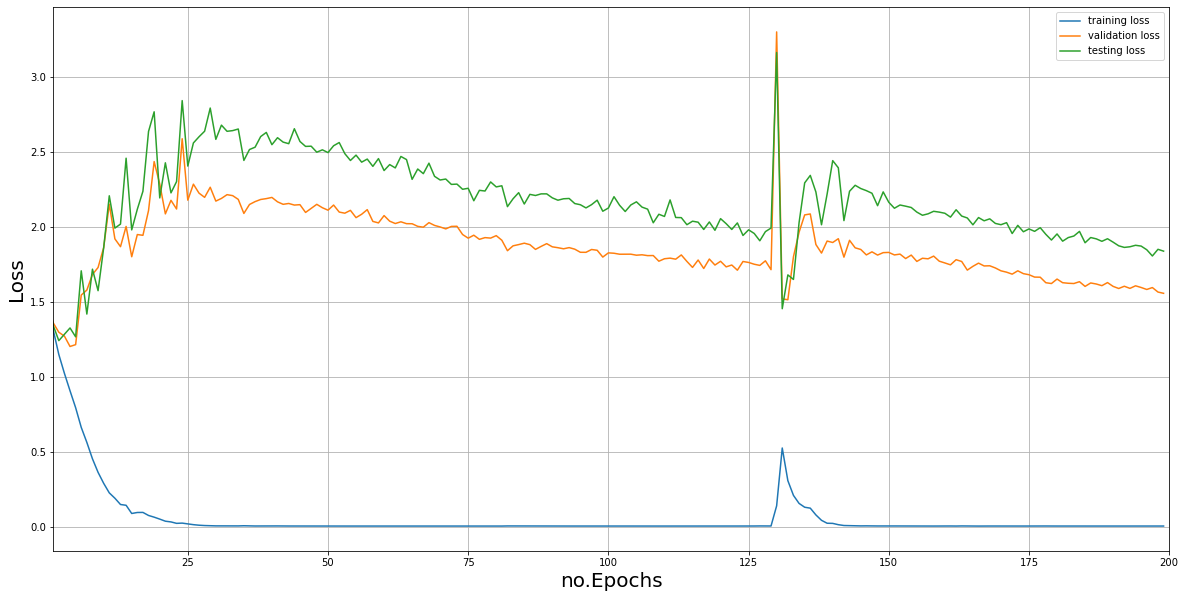

In [42]:
Items_baseline = list(baseline.items())
train_loss_vals,validation_loss_vals,test_loss_vals = Items_baseline[0][1],Items_baseline[1][1],Items_baseline[2][1]
x=range(len(train_loss_vals))
#Plotting
_,ax = plt.subplots(1,1,figsize=(20,10))
ax.plot(x,train_loss_vals)
ax.plot(x,validation_loss_vals)
ax.plot(x,test_loss_vals)
ax.grid('on')
plt.xlabel('no.Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)
ax.set_xlim(left=1, right=len(x))
ax.legend(['training loss', 'validation loss','testing loss ']);

`VGG16`

In [45]:
with open("saved_variables_fer\VGG16_200_epochs_.json", "r") as fp:
    V_16 = json.load(fp)

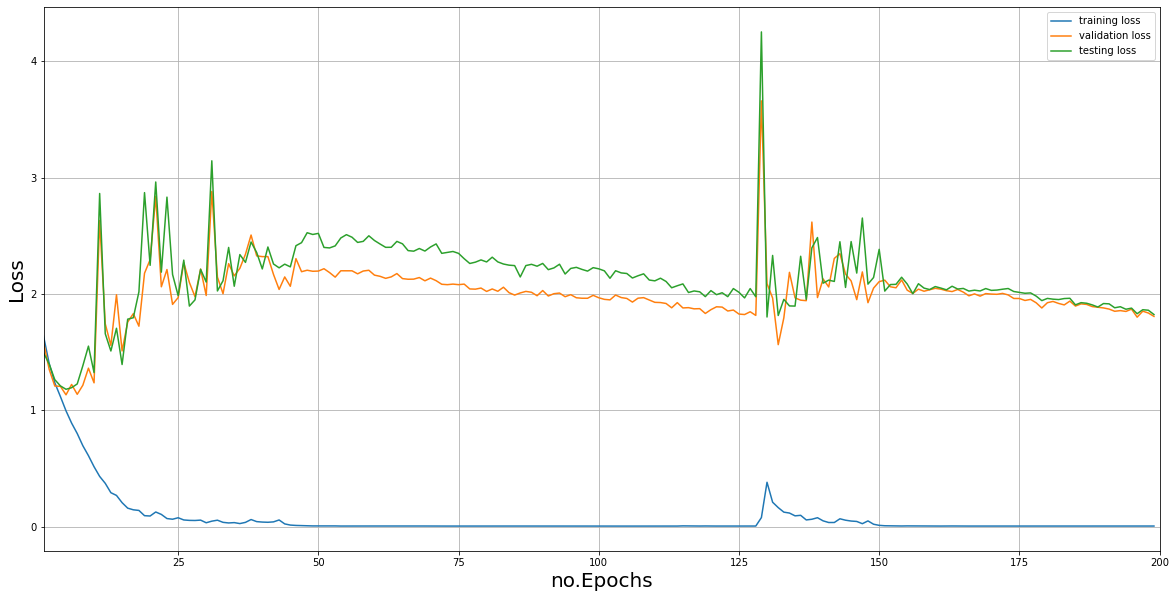

In [46]:
Items_V16 = list(V_16.items())
train_loss_vals,validation_loss_vals,test_loss_vals = Items_V16[0][1],Items_V16[1][1],Items_V16[2][1]
x=range(len(train_loss_vals))
#Plotting
_,ax = plt.subplots(1,1,figsize=(20,10))
ax.plot(x,train_loss_vals)
ax.plot(x,validation_loss_vals)
ax.plot(x,test_loss_vals)
ax.grid('on')
plt.xlabel('no.Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)
ax.set_xlim(left=1, right=len(x))
ax.legend(['training loss', 'validation loss','testing loss ']);

`VGG19`

In [47]:
with open("saved_variables_fer\VGG19_200_epochs_.json", "r") as fp:
    V_19 = json.load(fp)

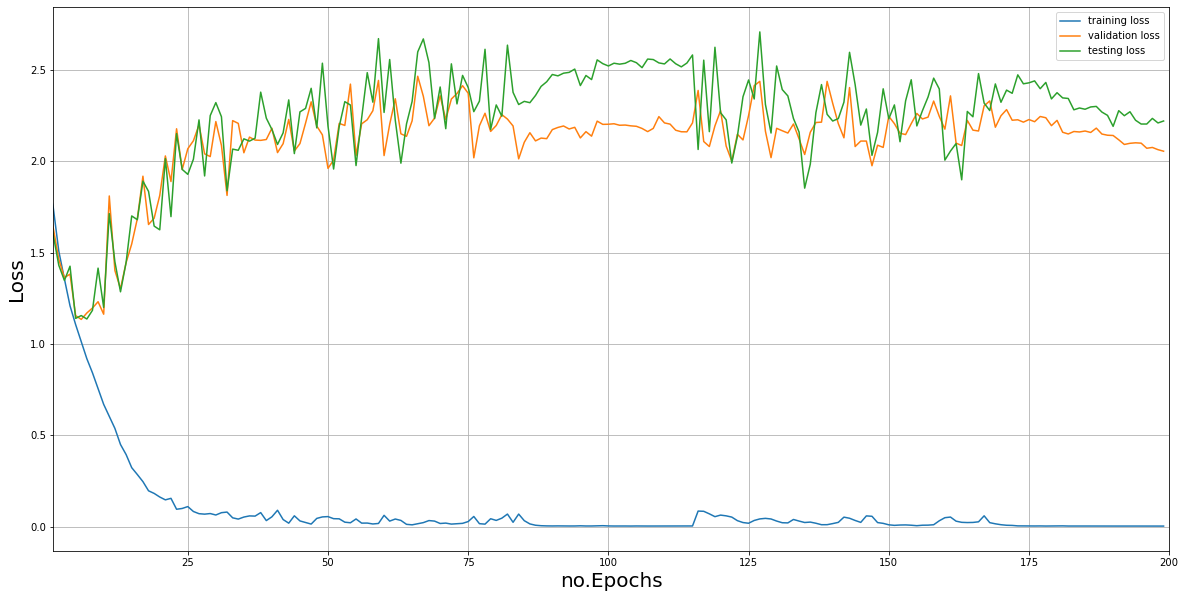

In [48]:
Items_V19 = list(V_19.items())
train_loss_vals,validation_loss_vals,test_loss_vals = Items_V19[0][1],Items_V19[1][1],Items_V19[2][1]
#Plotting
_,ax = plt.subplots(1,1,figsize=(20,10))
ax.plot(x,train_loss_vals)
ax.plot(x,validation_loss_vals)
ax.plot(x,test_loss_vals)
ax.grid('on')
plt.xlabel('no.Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)
ax.set_xlim(left=1, right=len(x))
ax.legend(['training loss', 'validation loss','testing loss ']);

`Attentional Networks`

In [49]:
with open("saved_variables_fer\Attentional_200_epochs_.json", "r") as fp:
    att = json.load(fp)

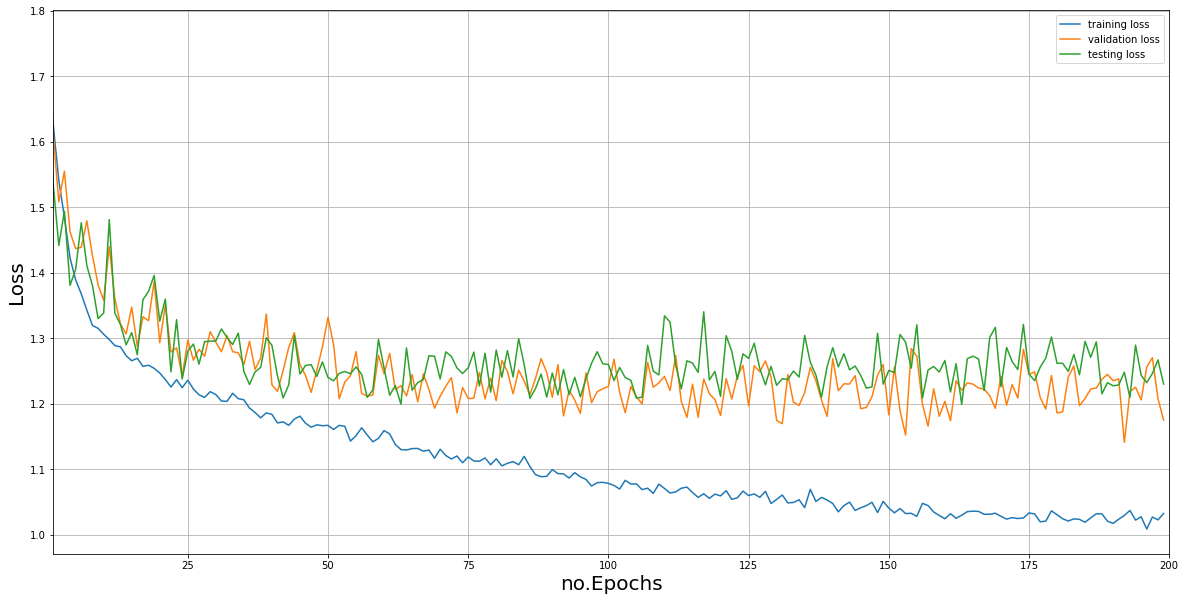

In [50]:
Items_att = list(att.items())
train_loss_vals,validation_loss_vals,test_loss_vals = Items_att[0][1],Items_att[1][1],Items_att[2][1]
#Plotting
_,ax = plt.subplots(1,1,figsize=(20,10))
ax.plot(x,train_loss_vals)
ax.plot(x,validation_loss_vals)
ax.plot(x,test_loss_vals)
ax.grid('on')
plt.xlabel('no.Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)
ax.set_xlim(left=1, right=len(x))
ax.legend(['training loss', 'validation loss','testing loss ']);

`Graph for all models loss values for testing data`

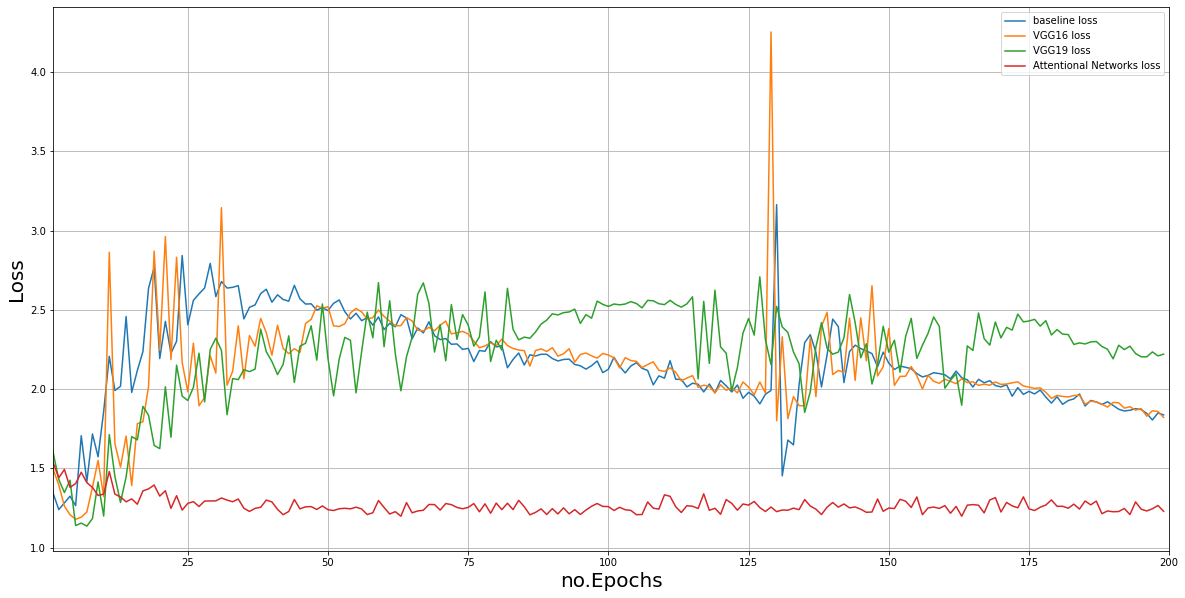

In [51]:

test_loss_baseline,test_loss_v16,test_loss_v19,test_loss_att = Items_baseline[2][1],Items_V16[2][1],Items_V19[2][1],Items_att[2][1]
#Plotting
_,ax = plt.subplots(1,1,figsize=(20,10))
ax.plot(x,test_loss_baseline)
ax.plot(x,test_loss_v16)
ax.plot(x,test_loss_v19)
ax.plot(x,test_loss_att)
ax.grid('on')
plt.xlabel('no.Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)
ax.set_xlim(left=1, right=len(x))
ax.legend(['baseline loss', 'VGG16 loss','VGG19 loss','Attentional Networks loss']);

### Performance Analysis

`Baseline Model`

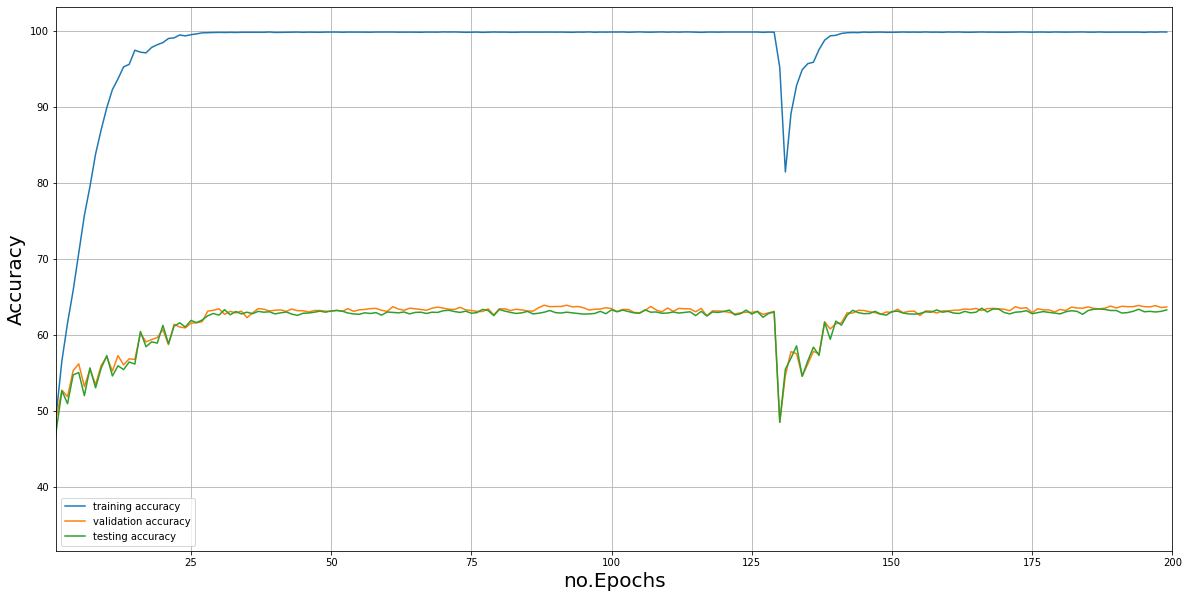

In [52]:
train_acc_vals,validation_acc_vals,test_acc_vals = Items_baseline[3][1],Items_baseline[4][1],Items_baseline[5][1]
x=range(len(train_acc_vals))
#Plotting
_,ax = plt.subplots(1,1,figsize=(20,10))
ax.plot(x,train_acc_vals)
ax.plot(x,validation_acc_vals)
ax.plot(x,test_acc_vals)
ax.grid('on')
plt.xlabel('no.Epochs', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
ax.set_xlim(left=1, right=len(x))
ax.legend(['training accuracy', 'validation accuracy','testing accuracy ']);

In [53]:
print(f'Highest validaction accuracy= {max(validation_acc_vals)}, Epoch of highest validation accuracy = {validation_acc_vals.index(max(validation_acc_vals))}')

Highest validaction accuracy= 63.86179994427417, Epoch of highest validation accuracy = 88


In [54]:
print(f'Highest test accuracy= {max(test_acc_vals)}, Epoch of highest test accuracy = {test_acc_vals.index(max(test_acc_vals))}')

Highest test accuracy= 63.471719141822234, Epoch of highest test accuracy = 166


`VGG16`

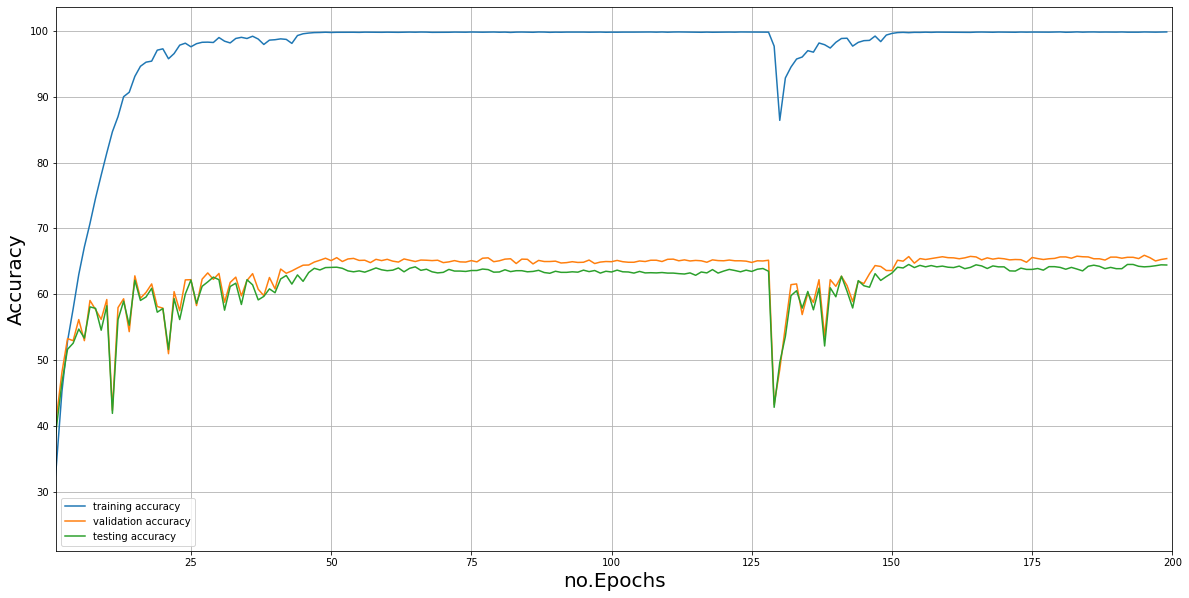

In [55]:
train_acc_vals,validation_acc_vals,test_acc_vals = Items_V16[3][1],Items_V16[4][1],Items_V16[5][1]
x=range(len(train_acc_vals))
#Plotting
_,ax = plt.subplots(1,1,figsize=(20,10))
ax.plot(x,train_acc_vals)
ax.plot(x,validation_acc_vals)
ax.plot(x,test_acc_vals)
ax.grid('on')
plt.xlabel('no.Epochs', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
ax.set_xlim(left=1, right=len(x))
ax.legend(['training accuracy', 'validation accuracy','testing accuracy ']);

In [56]:
print(f'Highest validaction accuracy= {max(validation_acc_vals)}, Epoch of highest validation accuracy = {validation_acc_vals.index(max(validation_acc_vals))}')

Highest validaction accuracy= 65.92365561437727, Epoch of highest validation accuracy = 195


In [57]:
print(f'Highest test accuracy= {max(test_acc_vals)}, Epoch of highest test accuracy = {test_acc_vals.index(max(test_acc_vals))}')

Highest test accuracy= 64.53050989133463, Epoch of highest test accuracy = 153


`VGG19`

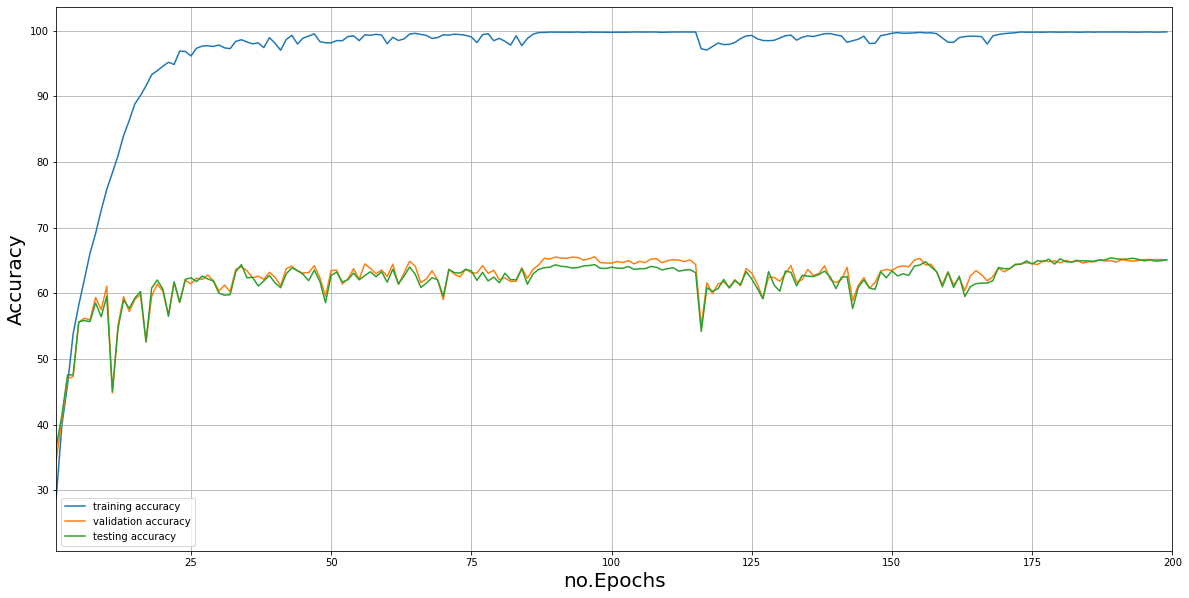

In [58]:
train_acc_vals,validation_acc_vals,test_acc_vals = Items_V19[3][1],Items_V19[4][1],Items_V19[5][1]
x=range(len(train_acc_vals))
#Plotting
_,ax = plt.subplots(1,1,figsize=(20,10))
ax.plot(x,train_acc_vals)
ax.plot(x,validation_acc_vals)
ax.plot(x,test_acc_vals)
ax.grid('on')
plt.xlabel('no.Epochs', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
ax.set_xlim(left=1, right=len(x))
ax.legend(['training accuracy', 'validation accuracy','testing accuracy ']);

In [59]:
print(f'Highest validaction accuracy= {max(validation_acc_vals)}, Epoch of highest validation accuracy = {validation_acc_vals.index(max(validation_acc_vals))}')

Highest validaction accuracy= 65.56143772638619, Epoch of highest validation accuracy = 97


In [60]:
print(f'Highest test accuracy= {max(test_acc_vals)}, Epoch of highest test accuracy = {test_acc_vals.index(max(test_acc_vals))}')

Highest test accuracy= 65.39426023962106, Epoch of highest test accuracy = 189


`Attentional Network `

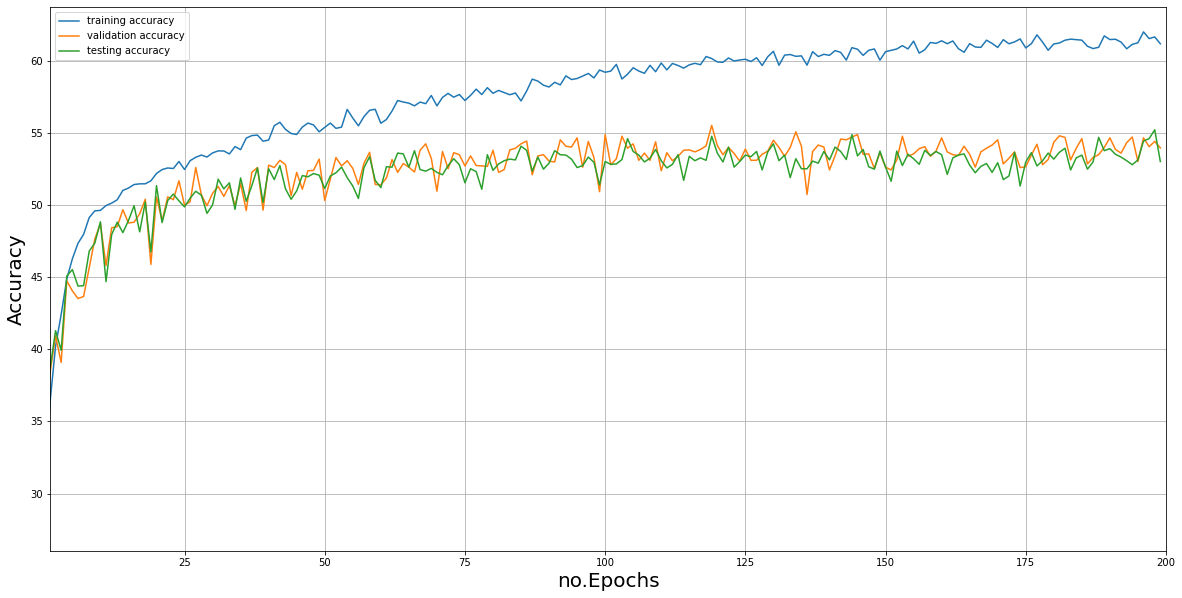

In [61]:
train_acc_vals,validation_acc_vals,test_acc_vals = Items_att[3][1],Items_att[4][1],Items_att[5][1]
x=range(len(train_acc_vals))
#Plotting
_,ax = plt.subplots(1,1,figsize=(20,10))
ax.plot(x,train_acc_vals)
ax.plot(x,validation_acc_vals)
ax.plot(x,test_acc_vals)
ax.grid('on')
plt.xlabel('no.Epochs', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
ax.set_xlim(left=1, right=len(x))
ax.legend(['training accuracy', 'validation accuracy','testing accuracy ']);

In [62]:
print(f'Highest validaction accuracy= {max(validation_acc_vals)}, Epoch of highest validation accuracy = {validation_acc_vals.index(max(validation_acc_vals))}')

Highest validaction accuracy= 55.53078852047925, Epoch of highest validation accuracy = 119


In [63]:
print(f'Highest test accuracy= {max(test_acc_vals)}, Epoch of highest test accuracy = {test_acc_vals.index(max(test_acc_vals))}')

Highest test accuracy= 55.224296461409864, Epoch of highest test accuracy = 198


`Graph for all models accuracy values for testing data`

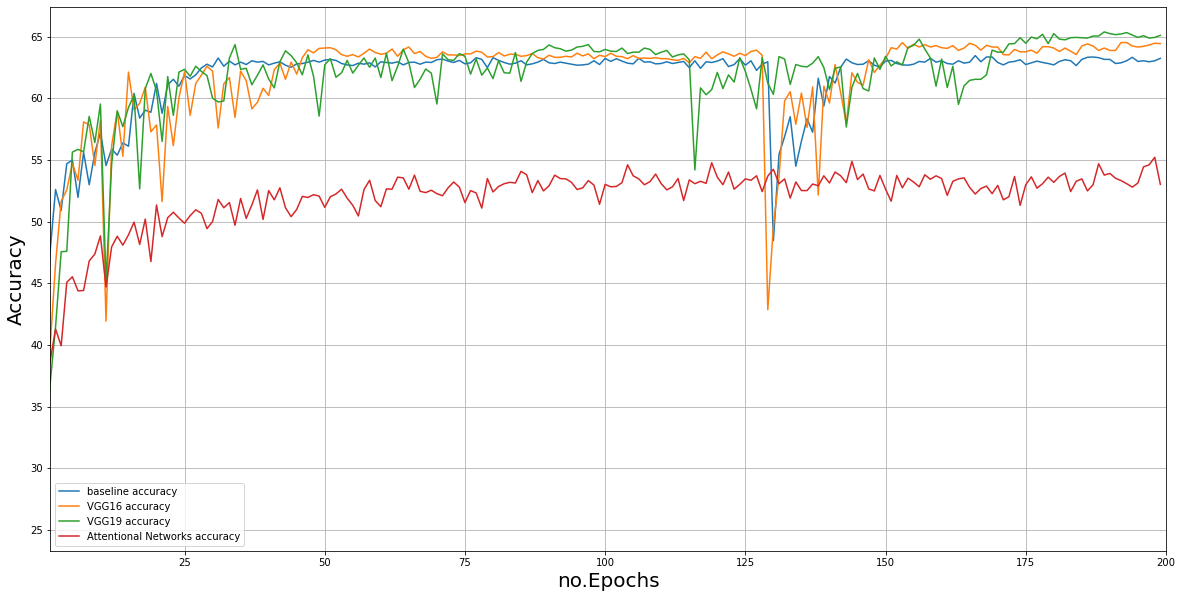

In [64]:

test_acc_baseline,test_acc_v16,test_acc_v19,test_acc_att = Items_baseline[5][1],Items_V16[5][1],Items_V19[5][1],Items_att[5][1]
#Plotting
_,ax = plt.subplots(1,1,figsize=(20,10))
ax.plot(x,test_acc_baseline)
ax.plot(x,test_acc_v16)
ax.plot(x,test_acc_v19)
ax.plot(x,test_acc_att)
ax.grid('on')
plt.xlabel('no.Epochs', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
ax.set_xlim(left=1, right=len(x))
ax.legend(['baseline accuracy', 'VGG16 accuracy','VGG19 accuracy','Attentional Networks accuracy']);

### Overall Evaluation

A summary of the models performances are showcased below.

| Models | Validation Accuracy| Epoch_validation | Testing Accuracy | Epoch_Testing
| --- | --- | --- | --- |--- |
| Baseline | 63.86 | 88 | 63.47 | 166| 
| VGG16 | 65.92 | 195 | 64.53 |153 |
| VGG19 | 65.56 | 97 | 65.39 | 189 |
| Attentional Network | 55.53 | 119 | 55.22 |198|

`VGG19` showed the highest accuracy for predicting the testing set with an accuracy of `65.39%` at an epoch of `189`.
On the other hand, `VGG16` showcased the superior accuracy value for the validation set with `65.92%` at an epoch of `195`

Since VGG showed exhibited the highest possible accuracy for the testing set. We apply data augmentation rectify the dataset unbalanced class problem.

| Models | Validation Accuracy| Epoch_validation | Testing Accuracy | Epoch_Testing
| --- | --- | --- | --- |--- | 
| VGG19 before Augmentation| 65.56 | 97 | 65.39 | 189 |
| VGG19 after Augmentation| 74.652 | 184 | 74.678 |188 |

The proportions above showcases how critical is the usage of data augmentation for improving the total accuracy. For instance, `VGG19` approximately increased by a margin of `10%` in accuracy after augmentation.

## Trial

In [73]:
def show_img(im, ax=None, figsize=(8,8)):
    if not ax: _,ax = plt.subplots(1,1,figsize=figsize)
    if len(im.shape)==2: im = np.tile(im[:,:,None], 3)
    ax.imshow(im[:,:,::-1]);
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    return ax 

In [ ]:
# cell no 4 
def show_imgs(ims, rows=1, figsize=(16,8), title=[None]):
    title = title*len(ims) if len(title) == 1 else title
    _,ax = plt.subplots(rows, len(ims)//rows, figsize=figsize)
    [show_img(im,ax_,title=tit) for im,ax_,tit in zip(ims,ax.flatten(),title)]
    return ax

Since `VGG19` showcased the highest accuracy, this model is loaded from `\saved_models_fer` to make few predictions

In [77]:
FILE = './Saved_Models_finals/VGG19_final.pth'
loaded_model  = VGG_net('VGG19')
loaded_model.load_state_dict(tc.load(FILE,map_location=device.type))

<All keys matched successfully>

A `Haar Cascade Classifier` is loaded to extract faces of any given input. 

In [78]:
path_haar = './Saved_Models_finals/haarcascade_frontalface_default.xml'
faceCascade = cv2.CascadeClassifier(path_haar)

The function below is defined to accept an image and detect the current emotion.

In [79]:

def emotion_img(input_img_src):
    img = cv2.imread(input_img_src)
    copy_img=img.copy()
    gray = cv2.cvtColor(copy_img, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(gray, 1.1, 4)
    x, y, w, h = faces[0][0],faces[0][1],faces[0][2],faces[0][3]
    gray = gray[y:y+h, x:x+w] #extracting face patch from grayscaled img
    final_image = cv2.resize(gray,(48,48))
    final_image = np.expand_dims(final_image,axis=0)
    final_image = np.expand_dims(final_image,axis=0)
    final_image = final_image/255.0 # normalization 
    μ,σ = (0.50774187, 0.25500908)
    final_image = (final_image-μ)/σ
    data = tc.from_numpy(final_image).float()
    data = data.to(device)
    output = loaded_model(data)
    index = tc.argmax(output).item()
    return i2c_fer[index]
     

In [85]:
happy_salah = '.\images\salah.jpg'

In [93]:
music('image',happy_salah)

# Emotion Recognition Using Audio

## Data Processing and Aquisition

### Dataset

#### RAVDESS

For our audio dataset we are using the Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) dataset (Livingston & Russo 2018). RAVDESS contains audio recordings by 12 actors and 12 actressed, speaking two sentences in various emotional tones.

For the purpose of our report, we are aiming to classify between happy, sad, angry and neutral emotions, so we selected these examples only for our dataset.

This came to a total of 672 audio files.

We read the metadata CSV file for our dataset as a pandas dataframe.

In [9]:
metadata = pd.read_csv('audio_dataset/audio_dataset.csv')
metadata.head(10)

,audio_file_name,image_file_name,classID,emotion
0,03-01-03-01-02-02-01.wav,03-01-03-01-02-02-01.png,0,happy
1,03-01-03-02-01-01-01.wav,03-01-03-02-01-01-01.png,0,happy
2,03-01-03-02-01-02-01.wav,03-01-03-02-01-02-01.png,0,happy
3,03-01-03-02-02-01-01.wav,03-01-03-02-02-01-01.png,0,happy
4,03-01-03-02-02-02-01.wav,03-01-03-02-02-02-01.png,0,happy
5,03-01-04-01-01-01-01.wav,03-01-04-01-01-01-01.png,1,sad
6,03-01-04-01-01-02-01.wav,03-01-04-01-01-02-01.png,1,sad
7,03-01-04-01-02-01-01.wav,03-01-04-01-02-01-01.png,1,sad
8,03-01-04-01-02-02-01.wav,03-01-04-01-02-02-01.png,1,sad
9,03-01-04-02-01-01-01.wav,03-01-04-02-01-01-01.png,1,sad


We can check the count of each emotion to make sure the dataset is not unbalanced.

In [10]:
metadata['emotion'].value_counts()

happy      192
angry      192
sad        192
neutral     96
Name: emotion, dtype: int64

#### Dataset examples

Below we can see playable example audio files from the dataset for a sentence said with happy and sad emotional tones.

In [11]:
# Happy sentence
filename = 'audio_dataset/03-01-03-01-01-01-01.wav'
ipd.Audio(filename)

In [12]:
# Sad sentence
filename = 'audio_dataset/03-01-04-01-01-01-01.wav'
ipd.Audio(filename)

### Feature extraction

#### Mel-Frequency Cepstral Coefficients

One feature we can extract to classify our audio are Mel-Frequency Cepstral Coefficients (MFCCs). MFCCs consider human perception for sound sensitivity at appropriate frequencies by converting the conventional frequency to Mel scale. The formula to convert frequency hertz to Mel scale is shown below (O'Shaughnessy 1997).

$$m = 2595\log _{10}\left( 1 + \frac{f}{700}\right)$$

MFCCs are commonly derived as follows (Sahidullah and Saha 2012): 

1.	Take Fourier transform (Transformation of functions depending on space or time into functions depending on spatial or temporal frequency) of the sound signal.
2.	Map the powers of the spectrum obtained above onto the Mel scale, using any of the overlapping window methods. 
3.	Take log of the powers at each of the Mel frequencies.
4.	Take discrete cosine transform of Mel log powers.
5.	MFCC are the amplitude of resulting spectrum.

We can use Librosa to get the audio time series data as a 2D array and the sample rate from our audio files.

In [13]:
data, sample_rate = librosa.load(filename, sr=None)
data, sample_rate

(array([-3.0517578e-05,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtype=float32),
 48000)

As we can see, Librosa automatically normalises the data to values between -1 and 1.

In [14]:
min(data), max(data)

(-0.036712646, 0.04562378)

We can then use our data and sample rate with Librosa to get the MFCCs of our audio files.

In [15]:
mfccs = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=80)
mfccs.shape

(80, 360)

Now we need to convert every audio file from our dataset to MFCCs ready for classification.

We define the path to our audio files.

In [16]:
path = 'audio_dataset/'

We write a function to extract and return the MFCCs.

In [17]:
def features_extractor(file_name):
    
    audio, sample_rate = librosa.load(file_name, sr=None, res_type='kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=80)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    
    return mfccs_scaled_features

Now we iterate through every audio file and extract the MFCCs and the classes into an array.

In [18]:
extracted_features = []

for index_num, row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(path), str(row["audio_file_name"]))
    class_labels=row["emotion"]
    data = features_extractor(file_name)
    extracted_features.append([data, class_labels])

0it [00:00, ?it/s]

Then we can convert the array into a pandas dataframe.

In [19]:
mfcc_df = pd.DataFrame(extracted_features, columns = ['feature', 'emotion'])
mfcc_df.head()

,feature,emotion
0,"[-683.9286, 74.13705, 1.061916, 17.890663, 6.3...",happy
1,"[-627.4205, 67.704384, -6.6694894, 9.967615, -...",happy
2,"[-591.9702, 72.971, -6.9058204, 4.6451464, 0.4...",happy
3,"[-554.2307, 70.283676, -10.080169, 11.619575, ...",happy
4,"[-568.1388, 70.80917, -8.760222, 11.967098, -2...",happy


We can check the shape of our dataframe to see that all 672 audio files now have MFCCs extracted.

In [20]:
mfcc_df.shape

(672, 2)

#### Spectrograms

Another way we can classify audio data is to respresent the signal strength of the audio over time in the form of a spectrogram. This allows us to treat the audio signals like an image and in turn perform image classification techniques on the spectrogram.

Steps involved in transforming sound file to Mel spectrogram (Medium 2021):

1.	Extract audio signal 
2.	Apply fast Fourier transform to convert from time domain to frequency domain.
3.	Convert frequency to log scale and colour dimension to decibels to form the spectrogram.
4.	Map frequency onto Mel scale to form Mel spectrogram.

We can use the Librosa library to display a waveplot of the audio signal.

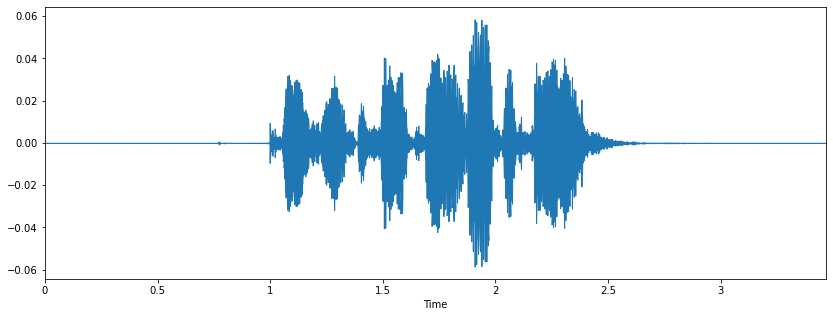

In [20]:
# Happy sentence
filename = 'audio_dataset/03-01-03-01-01-01-01.wav'
plt.figure(figsize=(14,5))
data, sample_rate = librosa.load(filename, sr=None)
librosa.display.waveplot(data,sr=sample_rate)

Then we can use a Fourier Transform and Specshow to display the audio as a mel spectrogram.

C:\Users\watso\anaconda3\envs\pytorch\lib\site-packages\librosa\core\spectrum.py:1642: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  "amplitude_to_db was called on complex input so phase "


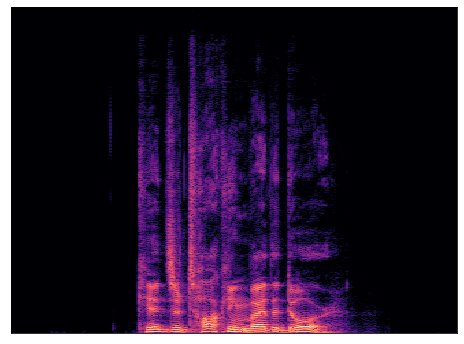

In [21]:
S = librosa.stft(data)
fig, ax = plt.subplots(figsize=(8,6))
mel = librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), ax=ax)

Above is the spectrogram for a happy sentence. We can display a sad sentence below to see the difference.

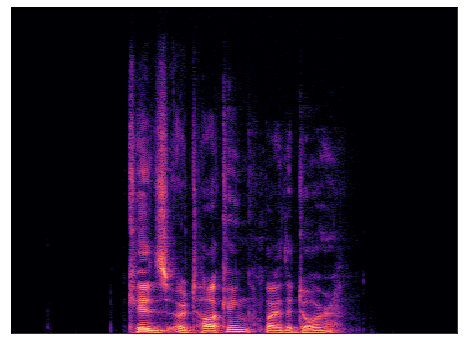

In [22]:
# Sad sentence
filename = 'audio_dataset/03-01-04-01-01-01-01.wav'
data, sample_rate = librosa.load(filename, sr=None)
S = librosa.stft(data)
fig, ax = plt.subplots(figsize=(8,6))
mel = librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), ax=ax)

As we can see the tonal differences make very slight changes in the spectrogram but still noticable, so we can use this to try and classify the audio.

Write a function to convert all our audio files into spectrograms and save them as images in our dataset folder.

In [23]:
def spectrogram_converter(file_name):
    audio, sample_rate = librosa.load(file_name, sr=None, res_type='kaiser_best')
    S = librosa.stft(audio)
    fig, ax = plt.subplots(figsize=(8,6))
    mel = librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), ax=ax)
    fig.savefig(str(file_name[:-4])+'.png')
    plt.close(fig)

Now we iterate through the audio files in our dataset, converting to spectrograms and saving as .png images of the same file name.

In [24]:
""" Just here to show the code used to convert and save files.
    No need to run. """
# plt.ioff()

# for index_num, row in tqdm(metadata.iterrows()):
#     file_name = os.path.join(os.path.abspath(path), str(row["audio_file_name"]))
#     spectrogram_converter(file_name)

# plt.ion()

' Just here to show the code used to convert and save files.\n    No need to run. '

Now we iterate through our metadata dataframe to create a new dataframe containing the spectrograms for our files and their classes.

In [25]:
data_array = []

for index_num, row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(path), str(row["image_file_name"]))
    class_labels=row["emotion"]
    im = cv2.imread(file_name)
    data_array.append([im, class_labels])
    
spectrogram_df = pd.DataFrame(data_array, columns = ['spectrogram', 'emotion'])
spectrogram_df.head()

0it [00:00, ?it/s]

,spectrogram,emotion
0,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",happy
1,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",happy
2,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",happy
3,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",happy
4,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",happy


We can check the shape of our dataframe to see that all 672 audio files now have mel spectrograms extracted.

In [26]:
spectrogram_df.shape

(672, 2)

### Training/Validation Split

#### Mel-Frequency Cepstral Coefficients

First we split the data into input data and output data arrays.

In [21]:
X = np.array(mfcc_df['feature'].tolist())
y = np.array(mfcc_df['emotion'].tolist())

Then we can check the shape of our arrays.

In [22]:
X.shape, y.shape

((672, 80), (672,))

We can create a dictionary to convert classes to integers for classification.

In [23]:
i2c = metadata.emotion.unique()
c2i = {k:v for v,k in enumerate(i2c)}
c2i

{'happy': 0, 'sad': 1, 'angry': 2, 'neutral': 3}

Now we can get the number of classes to be used later.

In [24]:
num_classes = len(i2c)
num_classes

4

We can now convert our output array into integers using our class to integer (c2i) list, and then convert the datatype to integer.

In [25]:
i = 0

for j in y:
    y[i] = c2i[j]
    i += 1
    
y = y.astype(np.int)

In [26]:
y[:20]

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2])

We can check that the integer to class (i2c) list converts the integers back to classes correctly.

In [27]:
i2c[y[:20]]

array(['happy', 'happy', 'happy', 'happy', 'happy', 'sad', 'sad', 'sad',
       'sad', 'sad', 'sad', 'sad', 'sad', 'angry', 'angry', 'angry',
       'angry', 'angry', 'angry', 'angry'], dtype=object)

Now we can split our data into training and validation sets using the random seed defined earlier.

We will use 80% of the data for training and 20% for testing.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state = seed)

Below we can check the shape of our training and test data to make sure everything is correct.

In [29]:
X_train.shape, y_train.shape

((537, 80), (537,))

In [30]:
X_test.shape, y_test.shape

((135, 80), (135,))

To classify our audio in a Convolutional Neural Network as MFCCs we will need to reshape the data to make it work with the convolutions and create a seperate dataset.

In [37]:
X_train_cnn = X_train.copy()
X_train_cnn = X_train_cnn.reshape(537, 1, 80)

X_test_cnn = X_test.copy()
X_test_cnn = X_test_cnn.reshape(135, 1, 80)

X_train_cnn.shape, X_test_cnn.shape

((537, 1, 80), (135, 1, 80))

#### Spectrograms

First we split the data into input data and output data arrays.

In [38]:
X = np.array(spectrogram_df['spectrogram'].tolist())
y = np.array(spectrogram_df['emotion'].tolist())

We convert the datatype to float32 to work with our classifiers.

In [39]:
X = X.astype('float32')/255

We check the shape of our data arrays.

In [40]:
X.shape, y.shape

((672, 432, 576, 3), (672,))

PyTorch requires the 3 RBG channels to come before the image height and width so we need to transpose our array.

In [41]:
X = np.moveaxis(X, -1, 1)
X.shape

(672, 3, 432, 576)

Now we need to normalise the data using the mean and standard deviation.

In [42]:
μ, σ = X.mean(), X.std()
μ, σ

(0.4646481, 0.46671736)

In [43]:
X = (X - μ) / σ

Now we can check the min and max values of X to make sure they're normalised.

In [44]:
np.min(X), np.max(X)

(-0.99556637, 1.147058)

We convert our output to integers for classification.

In [45]:
i = 0

for j in y:
    y[i] = c2i[j]
    i += 1
    
y = y.astype(np.int)

In [46]:
y[:20]

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2])

In [47]:
i2c[y[:20]]

array(['happy', 'happy', 'happy', 'happy', 'happy', 'sad', 'sad', 'sad',
       'sad', 'sad', 'sad', 'sad', 'sad', 'angry', 'angry', 'angry',
       'angry', 'angry', 'angry', 'angry'], dtype=object)

Now we can split our data into training and validation sets using the random seed defined earlier.

We will use 80% of the data for training and 20% for testing.

In [48]:
Xtr, Xval, ytr, yval = train_test_split(X,y,test_size=0.2, random_state = seed)

Below we can check the shape of our training and test data to make sure everything is correct.

In [49]:
Xtr.shape, ytr.shape

((537, 3, 432, 576), (537,))

In [50]:
Xval.shape, yval.shape

((135, 3, 432, 576), (135,))

### PyTorch Dataset and Dataloader

We will now define a PyTorch dataset class and use it to define our datasets and load our data into dataloaders ready for classification.

We will need three datasets for our different data:
 - MFCC
 - MFCC for CNN
 - Spectrograms

We define our AudioEmotion PyTorch Dataset class.

In [31]:
class AudioEmotion(Dataset):
    def __init__(self, x, y): self.x, self.y = tc.tensor(x).float(), tc.tensor(y).long()
    def __len__(self): return len(self.x)
    def __getitem__(self, ix): return self.x[ix], self.y[ix]

**MFCC:**

We initalise our MFCC data using our AudioEmotion class.

In [32]:
mfcc_tr_ds  = AudioEmotion(X_train, y_train)
mfcc_val_ds = AudioEmotion(X_test, y_test)

We set the batch size that our dataloaders will deliver our data to our models and initialise our dataloaders.

In [33]:
bs = 32
mfcc_tr_dl  = DataLoader(mfcc_tr_ds,  batch_size=bs,   shuffle=True,  num_workers=0)
mfcc_val_dl = DataLoader(mfcc_val_ds, batch_size=2*bs, shuffle=False, num_workers=0)

**MFCC for CNN:**

We repeat these steps for our MFCC for CNN dataset.

In [54]:
mfcc_cnn_tr_ds  = AudioEmotion(X_train_cnn, y_train)
mfcc_cnn_val_ds = AudioEmotion(X_test_cnn, y_test)

In [55]:
bs = 32
mfcc_cnn_tr_dl  = DataLoader(mfcc_cnn_tr_ds,  batch_size=bs,   shuffle=True,  num_workers=0)
mfcc_cnn_val_dl = DataLoader(mfcc_cnn_val_ds, batch_size=2*bs, shuffle=False, num_workers=0)

**Spectrograms:**

We repeat these steps for our Spectrogram dataset. We use a smaller batch size as the images are much more data than the MFCC arrays.

In [56]:
spec_tr_ds  = AudioEmotion(Xtr, ytr)
spec_val_ds = AudioEmotion(Xval, yval)

In [57]:
bs = 4
spec_tr_dl  = DataLoader(spec_tr_ds,  batch_size=bs,   shuffle=True,  num_workers=0)
spec_val_dl = DataLoader(spec_val_ds, batch_size=bs, shuffle=False, num_workers=0)

## Modelling

### Prediction Function

We can create a prediction function which will take the model and a filename as arguments and return the prediction.

In [34]:
def predict(model, filename):
    
    if filename[-4:] == '.wav':
        prediction_feature = features_extractor(filename)
        if model == LogReg:
            prediction_feature = prediction_feature
        elif model == ANN:
            prediction_feature = prediction_feature
        elif model == CNN_MFCC:
            prediction_feature = prediction_feature.reshape(1, 1, 80)
        prediction_feature = tc.as_tensor(prediction_feature).float().to(device)
        prediction = model(prediction_feature).cpu()
        prediction = np.argmax(prediction.detach().numpy())
        prediction = i2c[prediction]
        return prediction
    
    if filename[-4:] == '.png':
        im = cv2.imread(filename)
        im = im.astype('float32')/255
        im = np.moveaxis(im, -1, 0)
        im = im.reshape(1, 3, 432, 576)
        im = tc.as_tensor(im).float().to(device)
        prediction = model(im).cpu()
        prediction = np.argmax(prediction.detach().numpy())
        prediction = i2c[prediction]
        return prediction      

We can define a few filenames to test with the prediction function after classifying.

In [35]:
happy = 'audio_dataset/03-01-03-01-01-01-01.wav'

In [36]:
happy_im = 'audio_dataset/03-01-03-01-01-01-01.png'

In [37]:
angry = 'audio_dataset/03-01-05-01-01-01-01.wav'

In [38]:
angry_im = 'audio_dataset/03-01-05-01-01-01-01.png'

In [39]:
sad = 'audio_dataset/03-01-04-01-01-01-01.wav'

In [40]:
sad_im = 'audio_dataset/03-01-04-01-01-01-01.png'

In [41]:
neutral = 'audio_dataset/03-01-01-01-01-01-01.wav'

In [42]:
neutral_im = 'audio_dataset/03-01-01-01-01-01-01.png'

### Confusion Matrix

We write a function to display a confusion matrix to see the accuracy per class of our models.

In [43]:
def confusion(model, dataloader):

    # nb_classes = num_classes
    confusion_matrix = np.zeros((num_classes, num_classes))
    
    with tc.no_grad():
        for i, (xb, yb) in enumerate(dataloader):
            xb = xb.to(device)
            yb = yb.to(device)
            y_ = model(xb)
            _, pred = tc.max(y_, 1)
            for t, p in zip(yb.view(-1), pred.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1
                    
    # Plot the matrix
    plt.figure(figsize=(15,10))

    classes = list(i2c)
    df_cm = pd.DataFrame(confusion_matrix, index=classes, columns=classes).astype(int)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
    
    plt.ylabel('Actual class')
    plt.xlabel('Predicted class')

### Training/Validation Functions

We create a function for a single epoch of our dataset.

In [44]:
def single_epoch(model, criterion, dl, opt=None, eval_metric=None):
    
    # Set algorithm to train when given an optimiser and to evaluate when not.
    if opt:
        model.train()
    else:
        model.eval()
    
    # Create empty lists to save loss and evaluation metric
    Loss, Eval_metric = [], []

    # Iterate through the dataset, taking an optimisation step if an optimiser is given
    # and recording validation accuracy if not. Recording loss at each iteration.   
    dl_it = iter(dl)
    for xb, yb in tqdm(dl_it, leave=False):
        xb, yb = xb.to(device), yb.to(device)
        y_ = model(xb)
        loss = criterion(y_, yb)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        Loss.append(loss.detach().cpu().numpy())
        if eval_metric: Eval_metric.append(eval_metric(y_, yb).cpu().numpy())
                    
    return Loss, Eval_metric

We define our main training and validation function, plotting the training and validation loss for every epoch.

In [45]:
def train_val(model, tr_dl, val_dl, criterion=nn.CrossEntropyLoss(), epochs=5, lr=0.003, wd=0.001, plot=True):   
    
    # Set Adam as our optimiser
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    
    # Define our metric as accuracy to measure validation accuracy between the predicted class and the real class
    accuracy = lambda y_,yb: (y_.max(dim=1)[1] == yb).float().mean()
    
    # Define empty lists which we will append losses and accuracy at each epoch
    tr_loss, val_loss, val_acc = [], [], []
    
    # Run through our single_epoch function, recording losses and accuracy
    for epoch in trange(epochs):
        Loss_tr,  _    = single_epoch(model, criterion, tr_dl, opt)
        Loss_val, Acc_val = single_epoch(model, criterion, val_dl, None, accuracy)
        tr_loss.append(np.mean(Loss_tr))
        val_loss.append(np.mean(Loss_val))
        val_acc.append(np.mean(Acc_val))
        print(f'Epoch: {epoch+1}\tTraining loss: {np.mean(Loss_tr):0.4f}\tValidation loss: {np.mean(Loss_val):0.4f}\tValidation accuracy: {np.mean(Acc_val):0.2f}')
        
        # Save model with best accuracy with for each model type
        if np.mean(Acc_val) >= max(val_acc) or len(val_acc) == 0:
            if model == LogReg:
                PATH = f'./saved_model/LogReg.pth'
                tc.save(model.state_dict(), PATH)
            elif model == ANN:
                PATH = f'./saved_model/ANN.pth'
                tc.save(model.state_dict(), PATH)
            elif model == CNN_MFCC:
                PATH = f'./saved_model/CNN_MFCC.pth'
                tc.save(model.state_dict(), PATH)
            elif model == CNN:
                PATH = f'./saved_model/CNN.pth'
                tc.save(model.state_dict(), PATH)
            elif model == alexnet:
                PATH = f'./saved_model/alexnet.pth'
                tc.save(model.state_dict(), PATH)
            elif model == vgg16:
                PATH = f'./saved_model/vgg16.pth'
                tc.save(model.state_dict(), PATH)
            elif model == resnet34:
                PATH = f'./saved_model/resnet34.pth'
                tc.save(model.state_dict(), PATH)
            elif model == sqnet:
                PATH = f'./saved_model/sqnet.pth'
                tc.save(model.state_dict(), PATH)
            elif model == mbnet:
                PATH = f'./saved_model/mbnet.pth'
                tc.save(model.state_dict(), PATH)
        
    # If plot = True, plot the training/validation losses and validation accuracy 
    if plot:
        _,ax = plt.subplots(2,1,figsize=(16,8))
        ax[0].plot(1+np.arange(len(tr_loss)),tr_loss)
        ax[0].plot(1+np.arange(len(val_loss)),val_loss)
        ax[0].grid('on')
        ax[0].set_xlim(left=1, right=len(tr_loss))
        ax[0].legend(['Training loss', 'Validation loss']);
        
        ax[1].plot(1+np.arange(len(val_acc)),val_acc)
        ax[1].grid('on')
        ax[1].set_xlim(left=1, right=len(val_acc))
        ax[1].legend(['Validation Accuracy']);
        
    return tr_loss, val_loss

### MFCC

For our classification using Mel Frequency Cepstral Coefficients (MFCCs), we will create three algorithms. A logistic regression model, an Artificial Neural Network (ANN) and a Convolutional Neural Network (CNN).

#### Logistic Regression

We define our Logistic Regression model using PyTorch nn.Sequential.

In [46]:
LogReg = nn.Sequential(
    nn.Linear(in_features=80,  out_features=num_classes)
).to(device)

LogReg

Sequential(
  (0): Linear(in_features=80, out_features=4, bias=True)
)

We run our model through our training/validation function.

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1	Training loss: 19.2801	Validation loss: 2.9590	Validation accuracy: 0.29


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 2	Training loss: 4.1056	Validation loss: 2.5164	Validation accuracy: 0.35


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 3	Training loss: 1.9852	Validation loss: 1.3388	Validation accuracy: 0.49


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 4	Training loss: 1.4599	Validation loss: 1.2087	Validation accuracy: 0.59


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 5	Training loss: 1.2615	Validation loss: 1.1503	Validation accuracy: 0.57


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 6	Training loss: 1.0960	Validation loss: 1.0623	Validation accuracy: 0.54


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 7	Training loss: 0.9917	Validation loss: 1.0473	Validation accuracy: 0.54


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 8	Training loss: 0.9216	Validation loss: 1.0017	Validation accuracy: 0.59


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 9	Training loss: 0.8737	Validation loss: 1.0124	Validation accuracy: 0.59


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 10	Training loss: 0.8559	Validation loss: 0.9675	Validation accuracy: 0.58


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 11	Training loss: 0.8589	Validation loss: 1.0080	Validation accuracy: 0.59


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 12	Training loss: 0.8186	Validation loss: 1.4015	Validation accuracy: 0.49


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 13	Training loss: 0.8919	Validation loss: 0.9739	Validation accuracy: 0.60


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 14	Training loss: 0.7773	Validation loss: 0.8852	Validation accuracy: 0.64


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 15	Training loss: 0.7653	Validation loss: 0.9759	Validation accuracy: 0.65


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 16	Training loss: 0.7710	Validation loss: 1.0591	Validation accuracy: 0.49


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 17	Training loss: 0.7506	Validation loss: 0.9170	Validation accuracy: 0.63


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 18	Training loss: 0.7258	Validation loss: 0.8756	Validation accuracy: 0.66


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 19	Training loss: 0.7361	Validation loss: 0.9704	Validation accuracy: 0.53


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 20	Training loss: 0.6847	Validation loss: 0.9249	Validation accuracy: 0.65


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 21	Training loss: 0.6842	Validation loss: 0.8957	Validation accuracy: 0.66


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 22	Training loss: 0.6922	Validation loss: 0.9052	Validation accuracy: 0.66


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 23	Training loss: 0.7322	Validation loss: 1.0750	Validation accuracy: 0.51


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 24	Training loss: 0.7015	Validation loss: 0.9174	Validation accuracy: 0.67


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 25	Training loss: 0.6600	Validation loss: 0.9481	Validation accuracy: 0.64


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 26	Training loss: 0.6944	Validation loss: 0.9724	Validation accuracy: 0.57


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 27	Training loss: 0.6376	Validation loss: 1.0104	Validation accuracy: 0.58


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 28	Training loss: 0.6903	Validation loss: 0.8931	Validation accuracy: 0.58


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 29	Training loss: 0.6563	Validation loss: 0.9020	Validation accuracy: 0.67


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 30	Training loss: 0.6402	Validation loss: 0.9599	Validation accuracy: 0.62
Wall time: 3.71 s


([19.2801,
  4.1056204,
  1.9851812,
  1.4598794,
  1.2614527,
  1.096021,
  0.9916997,
  0.921587,
  0.87371266,
  0.85589635,
  0.8589358,
  0.8185842,
  0.89193755,
  0.7772517,
  0.7652931,
  0.770951,
  0.75062937,
  0.7258351,
  0.73611516,
  0.6847375,
  0.68422556,
  0.69216365,
  0.732224,
  0.7014642,
  0.6599946,
  0.6944051,
  0.63761914,
  0.6903101,
  0.65626496,
  0.64019877],
 [2.9589956,
  2.5164201,
  1.3387723,
  1.2086592,
  1.150318,
  1.0622988,
  1.047305,
  1.0017403,
  1.0123901,
  0.96746606,
  1.0080075,
  1.4015175,
  0.9739005,
  0.88515896,
  0.97588843,
  1.0591265,
  0.9170339,
  0.87560064,
  0.9704301,
  0.92488736,
  0.89574736,
  0.90517014,
  1.0750057,
  0.91741115,
  0.9480846,
  0.97242516,
  1.0103774,
  0.8930939,
  0.9019622,
  0.95987517])

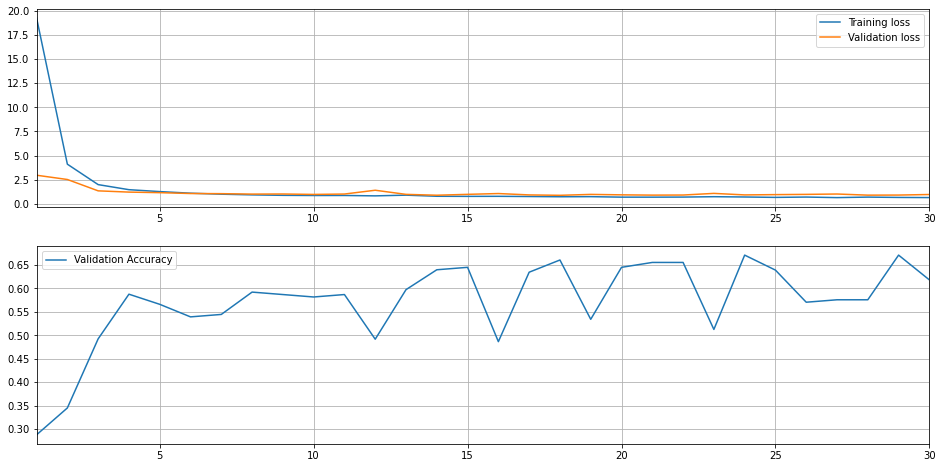

In [71]:
%%time
train_val(LogReg, mfcc_tr_dl, mfcc_val_dl, epochs=30, lr=0.003);

We load the model state of our logistic regression with the best accuracy.

In [47]:
LogReg.load_state_dict(tc.load('saved_model/LogReg.pth'))
LogReg.eval

<bound method Module.eval of Sequential(
  (0): Linear(in_features=80, out_features=4, bias=True)
)>

We predict on the audio files we defined earlier.

In [48]:
%%time
print(predict(LogReg, happy))

happy
Wall time: 538 ms


In [49]:
%%time
print(predict(LogReg, angry))

angry
Wall time: 18 ms


In [50]:
%%time
print(predict(LogReg, sad))

sad
Wall time: 17 ms


In [51]:
%%time
print(predict(LogReg, neutral))

happy
Wall time: 16 ms


We visualise the accuracy per class using our confusion matrix function.

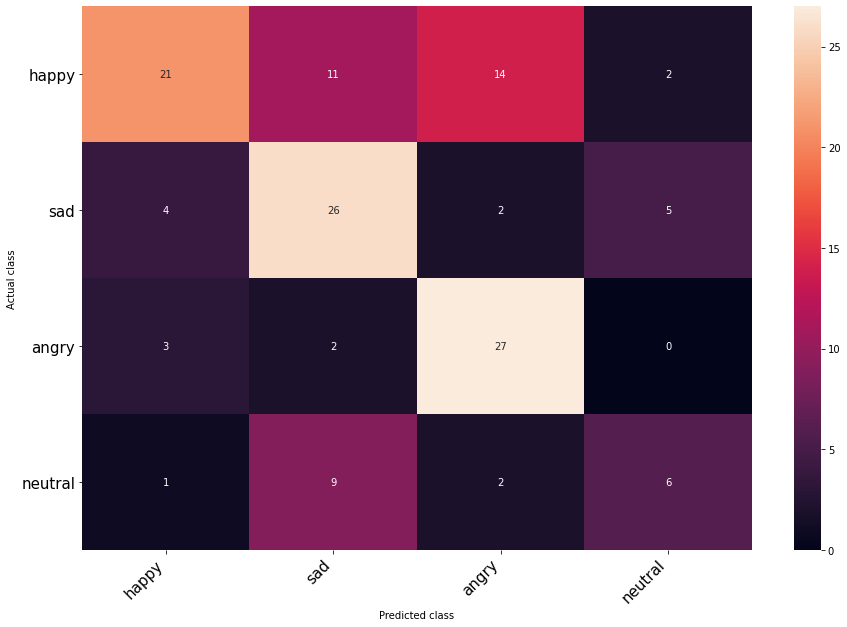

In [77]:
confusion(LogReg, mfcc_val_dl)

#### Artificial Neural Network (ANN)

We define our Artificial Neural Network (ANN) model using PyTorch nn.Sequential.

In [78]:
ANN = nn.Sequential(
    nn.Linear(in_features=80,  out_features=160), nn.ReLU(inplace=True), nn.Dropout(p=0.4),
    nn.Linear(in_features=160, out_features=240), nn.ReLU(inplace=True), nn.Dropout(p=0.4),
    nn.Linear(in_features=240, out_features=160), nn.ReLU(inplace=True), nn.Dropout(p=0.4),
    nn.Linear(in_features=160, out_features=num_classes)
).to(device)

ANN

Sequential(
  (0): Linear(in_features=80, out_features=160, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=160, out_features=240, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.4, inplace=False)
  (6): Linear(in_features=240, out_features=160, bias=True)
  (7): ReLU(inplace=True)
  (8): Dropout(p=0.4, inplace=False)
  (9): Linear(in_features=160, out_features=4, bias=True)
)

We run our model through our training/validation function.

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1	Training loss: 3.1556	Validation loss: 1.4117	Validation accuracy: 0.15


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 2	Training loss: 1.5117	Validation loss: 1.3404	Validation accuracy: 0.36


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 3	Training loss: 1.4169	Validation loss: 1.3541	Validation accuracy: 0.20


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 4	Training loss: 1.3548	Validation loss: 1.3122	Validation accuracy: 0.29


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 5	Training loss: 1.3337	Validation loss: 1.2563	Validation accuracy: 0.46


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 6	Training loss: 1.3157	Validation loss: 1.2294	Validation accuracy: 0.40


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 7	Training loss: 1.2667	Validation loss: 1.2500	Validation accuracy: 0.37


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 8	Training loss: 1.2403	Validation loss: 1.2142	Validation accuracy: 0.42


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 9	Training loss: 1.2200	Validation loss: 1.1999	Validation accuracy: 0.37


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 10	Training loss: 1.2086	Validation loss: 1.1962	Validation accuracy: 0.47


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 11	Training loss: 1.1912	Validation loss: 1.1532	Validation accuracy: 0.50


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 12	Training loss: 1.1381	Validation loss: 1.1906	Validation accuracy: 0.47


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 13	Training loss: 1.1395	Validation loss: 1.1203	Validation accuracy: 0.46


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 14	Training loss: 1.1017	Validation loss: 1.2006	Validation accuracy: 0.43


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 15	Training loss: 1.1333	Validation loss: 1.1056	Validation accuracy: 0.52


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 16	Training loss: 1.0830	Validation loss: 1.0619	Validation accuracy: 0.56


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 17	Training loss: 1.0825	Validation loss: 1.0817	Validation accuracy: 0.51


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 18	Training loss: 1.0408	Validation loss: 1.0609	Validation accuracy: 0.61


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 19	Training loss: 1.0550	Validation loss: 1.1344	Validation accuracy: 0.48


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 20	Training loss: 1.0012	Validation loss: 1.1605	Validation accuracy: 0.49


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 21	Training loss: 1.0190	Validation loss: 1.0617	Validation accuracy: 0.56


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 22	Training loss: 0.9772	Validation loss: 1.0206	Validation accuracy: 0.62


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 23	Training loss: 1.0022	Validation loss: 1.0676	Validation accuracy: 0.53


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 24	Training loss: 0.9691	Validation loss: 1.0478	Validation accuracy: 0.52


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 25	Training loss: 0.9556	Validation loss: 1.0250	Validation accuracy: 0.54


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 26	Training loss: 0.9316	Validation loss: 0.9722	Validation accuracy: 0.57


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 27	Training loss: 0.9612	Validation loss: 0.9712	Validation accuracy: 0.56


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 28	Training loss: 0.9734	Validation loss: 1.0483	Validation accuracy: 0.55


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 29	Training loss: 0.9775	Validation loss: 0.9946	Validation accuracy: 0.47


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 30	Training loss: 0.9557	Validation loss: 1.1965	Validation accuracy: 0.45
Wall time: 6.29 s


([3.155628,
  1.5116642,
  1.4169326,
  1.3548424,
  1.3336655,
  1.3156688,
  1.2666894,
  1.2402868,
  1.2199988,
  1.2085543,
  1.1911805,
  1.1381128,
  1.1395044,
  1.1016697,
  1.1333182,
  1.0829643,
  1.0825166,
  1.0408335,
  1.05501,
  1.0012454,
  1.018983,
  0.97718024,
  1.0022407,
  0.9691208,
  0.9555692,
  0.931563,
  0.9611961,
  0.9734211,
  0.9774752,
  0.95574254],
 [1.4116951,
  1.3403527,
  1.3540691,
  1.3122109,
  1.2563378,
  1.2293929,
  1.2500073,
  1.2141699,
  1.19991,
  1.1961607,
  1.1532041,
  1.1906174,
  1.1203039,
  1.2006017,
  1.1056355,
  1.0618958,
  1.0817101,
  1.060867,
  1.134396,
  1.1604687,
  1.0617256,
  1.0205573,
  1.0675532,
  1.0478164,
  1.025048,
  0.9721635,
  0.97119325,
  1.0483197,
  0.9946008,
  1.1964798])

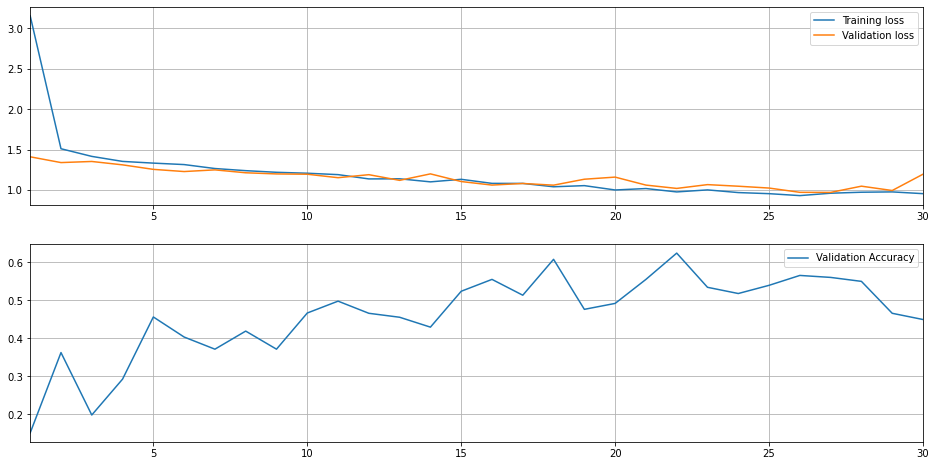

In [79]:
%%time
train_val(ANN, mfcc_tr_dl, mfcc_val_dl, epochs=30, lr=0.003);

We load the model state of our ANN with the best accuracy.

In [80]:
ANN.load_state_dict(tc.load('saved_model/ANN.pth'))
ANN.eval

<bound method Module.eval of Sequential(
  (0): Linear(in_features=80, out_features=160, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=160, out_features=240, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.4, inplace=False)
  (6): Linear(in_features=240, out_features=160, bias=True)
  (7): ReLU(inplace=True)
  (8): Dropout(p=0.4, inplace=False)
  (9): Linear(in_features=160, out_features=4, bias=True)
)>

We predict on the audio files we defined earlier.

In [81]:
%%time
print(predict(ANN, happy))

happy
Wall time: 17 ms


In [82]:
%%time
print(predict(ANN, angry))

angry
Wall time: 18 ms


In [83]:
%%time
print(predict(ANN, sad))

sad
Wall time: 20 ms


In [84]:
%%time
print(predict(ANN, neutral))

sad
Wall time: 16 ms


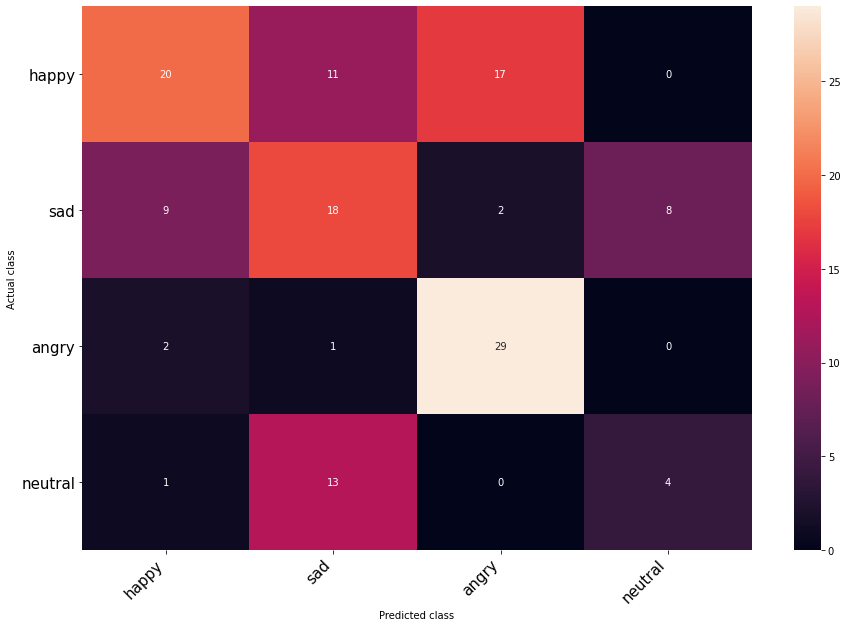

In [85]:
confusion(ANN, mfcc_val_dl)

#### Convolutional Neural Network (CNN)

We define our Convolution Neural Network (CNN) for MFCC model using PyTorch nn.Sequential.

In [86]:
CNN_MFCC = nn.Sequential(
    nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1), nn.ReLU(inplace=True),
    nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3, stride=2, padding=1), nn.ReLU(inplace=True),
    nn.MaxPool1d(kernel_size=2, stride=2), nn.Dropout(p=0.4),
    nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1), nn.ReLU(inplace=True), 
    nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1), nn.ReLU(inplace=True), 
    nn.MaxPool1d(kernel_size=2, stride=2), nn.Dropout(p=0.4),
    nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1), nn.ReLU(inplace=True), 
    nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1), nn.ReLU(inplace=True),
    nn.AdaptiveAvgPool1d((10)), nn.Dropout(p=0.4),
    nn.Flatten(),
    nn.Linear(in_features=(64*10), out_features=100), nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=100, out_features=num_classes)
).to(device)

CNN_MFCC

Sequential(
  (0): Conv1d(1, 16, kernel_size=(3,), stride=(2,), padding=(1,))
  (1): ReLU(inplace=True)
  (2): Conv1d(16, 16, kernel_size=(3,), stride=(2,), padding=(1,))
  (3): ReLU(inplace=True)
  (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Dropout(p=0.4, inplace=False)
  (6): Conv1d(16, 32, kernel_size=(3,), stride=(2,), padding=(1,))
  (7): ReLU(inplace=True)
  (8): Conv1d(32, 32, kernel_size=(3,), stride=(2,), padding=(1,))
  (9): ReLU(inplace=True)
  (10): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): Dropout(p=0.4, inplace=False)
  (12): Conv1d(32, 64, kernel_size=(3,), stride=(2,), padding=(1,))
  (13): ReLU(inplace=True)
  (14): Conv1d(64, 64, kernel_size=(3,), stride=(2,), padding=(1,))
  (15): ReLU(inplace=True)
  (16): AdaptiveAvgPool1d(output_size=10)
  (17): Dropout(p=0.4, inplace=False)
  (18): Flatten(start_dim=1, end_dim=-1)
  (19): Linear(in_features=640, out_features=100, bias=True)
  (20

We run our model through our training/validation function.

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1	Training loss: 1.3872	Validation loss: 1.3705	Validation accuracy: 0.33


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 2	Training loss: 1.3605	Validation loss: 1.3499	Validation accuracy: 0.36


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 3	Training loss: 1.3620	Validation loss: 1.3667	Validation accuracy: 0.17


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 4	Training loss: 1.3416	Validation loss: 1.3123	Validation accuracy: 0.20


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 5	Training loss: 1.3266	Validation loss: 1.3049	Validation accuracy: 0.33


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 6	Training loss: 1.2915	Validation loss: 1.2692	Validation accuracy: 0.30


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 7	Training loss: 1.2473	Validation loss: 1.2589	Validation accuracy: 0.36


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 8	Training loss: 1.2470	Validation loss: 1.2412	Validation accuracy: 0.36


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 9	Training loss: 1.2184	Validation loss: 1.2474	Validation accuracy: 0.36


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 10	Training loss: 1.2593	Validation loss: 1.2317	Validation accuracy: 0.36


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 11	Training loss: 1.2246	Validation loss: 1.2576	Validation accuracy: 0.31


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 12	Training loss: 1.2094	Validation loss: 1.3333	Validation accuracy: 0.23


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 13	Training loss: 1.2128	Validation loss: 1.2707	Validation accuracy: 0.33


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 14	Training loss: 1.1876	Validation loss: 1.2519	Validation accuracy: 0.31


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 15	Training loss: 1.1559	Validation loss: 1.3032	Validation accuracy: 0.31


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 16	Training loss: 1.1983	Validation loss: 1.2351	Validation accuracy: 0.36


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 17	Training loss: 1.1843	Validation loss: 1.2038	Validation accuracy: 0.38


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 18	Training loss: 1.1673	Validation loss: 1.2632	Validation accuracy: 0.31


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 19	Training loss: 1.1450	Validation loss: 1.2079	Validation accuracy: 0.38


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 20	Training loss: 1.1869	Validation loss: 1.1962	Validation accuracy: 0.47


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 21	Training loss: 1.1380	Validation loss: 1.2490	Validation accuracy: 0.39


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 22	Training loss: 1.1011	Validation loss: 1.2041	Validation accuracy: 0.38


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 23	Training loss: 1.1078	Validation loss: 1.2110	Validation accuracy: 0.45


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 24	Training loss: 1.0730	Validation loss: 1.1896	Validation accuracy: 0.45


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 25	Training loss: 1.1034	Validation loss: 1.1310	Validation accuracy: 0.52


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 26	Training loss: 1.0898	Validation loss: 1.1344	Validation accuracy: 0.49


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 27	Training loss: 1.1034	Validation loss: 1.1241	Validation accuracy: 0.52


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 28	Training loss: 1.0674	Validation loss: 1.2146	Validation accuracy: 0.45


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 29	Training loss: 1.0849	Validation loss: 1.0969	Validation accuracy: 0.50


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 30	Training loss: 1.0357	Validation loss: 1.2125	Validation accuracy: 0.41
Wall time: 13.6 s


([1.3871839,
  1.3605375,
  1.3619548,
  1.3416322,
  1.3266166,
  1.2914528,
  1.2472908,
  1.2470013,
  1.2183985,
  1.2593212,
  1.22459,
  1.2093709,
  1.2128165,
  1.1875538,
  1.1558565,
  1.1982574,
  1.1842924,
  1.1672593,
  1.145005,
  1.1869322,
  1.1379596,
  1.1010941,
  1.1077837,
  1.0730151,
  1.1033645,
  1.0897741,
  1.1033826,
  1.0673822,
  1.084875,
  1.0356996],
 [1.3705,
  1.3498665,
  1.3667216,
  1.3122741,
  1.3048959,
  1.2692246,
  1.2588941,
  1.2412294,
  1.2474047,
  1.231651,
  1.2576495,
  1.3332806,
  1.270738,
  1.2519498,
  1.3032492,
  1.2351018,
  1.2037792,
  1.2632394,
  1.2078902,
  1.1962351,
  1.2490047,
  1.2041177,
  1.2109741,
  1.1896244,
  1.1309859,
  1.1344337,
  1.124144,
  1.2145644,
  1.096929,
  1.2125419])

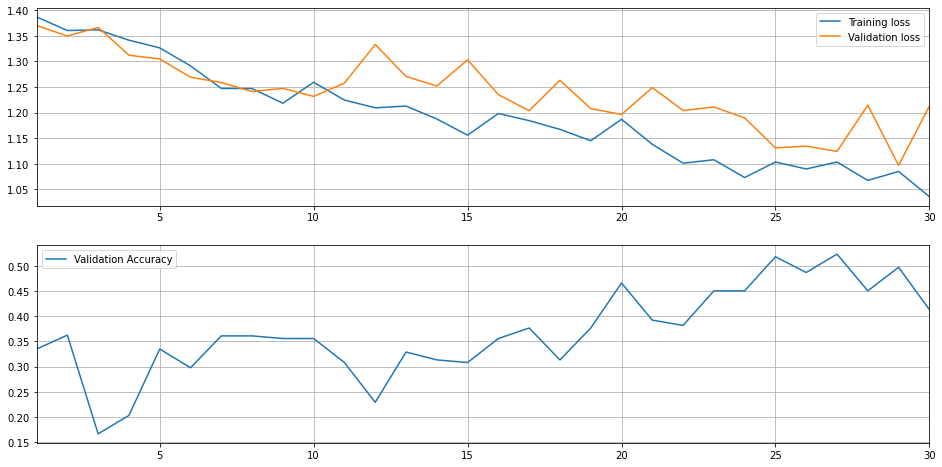

In [87]:
%%time
train_val(CNN_MFCC, mfcc_cnn_tr_dl, mfcc_cnn_val_dl, epochs=30, lr=0.003);

We load the model state of our CNN with the best accuracy.

In [88]:
CNN_MFCC.load_state_dict(tc.load('saved_model/CNN_MFCC.pth'))
CNN_MFCC.eval

<bound method Module.eval of Sequential(
  (0): Conv1d(1, 16, kernel_size=(3,), stride=(2,), padding=(1,))
  (1): ReLU(inplace=True)
  (2): Conv1d(16, 16, kernel_size=(3,), stride=(2,), padding=(1,))
  (3): ReLU(inplace=True)
  (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Dropout(p=0.4, inplace=False)
  (6): Conv1d(16, 32, kernel_size=(3,), stride=(2,), padding=(1,))
  (7): ReLU(inplace=True)
  (8): Conv1d(32, 32, kernel_size=(3,), stride=(2,), padding=(1,))
  (9): ReLU(inplace=True)
  (10): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): Dropout(p=0.4, inplace=False)
  (12): Conv1d(32, 64, kernel_size=(3,), stride=(2,), padding=(1,))
  (13): ReLU(inplace=True)
  (14): Conv1d(64, 64, kernel_size=(3,), stride=(2,), padding=(1,))
  (15): ReLU(inplace=True)
  (16): AdaptiveAvgPool1d(output_size=10)
  (17): Dropout(p=0.4, inplace=False)
  (18): Flatten(start_dim=1, end_dim=-1)
  (19): Linear(in_features=640, out_f

In [89]:
%%time
print(predict(CNN_MFCC, happy))

happy
Wall time: 27 ms


In [90]:
%%time
print(predict(CNN_MFCC, angry))

angry
Wall time: 22 ms


In [91]:
%%time
print(predict(CNN_MFCC, sad))

sad
Wall time: 25 ms


In [92]:
%%time
print(predict(CNN_MFCC, neutral))

sad
Wall time: 20 ms


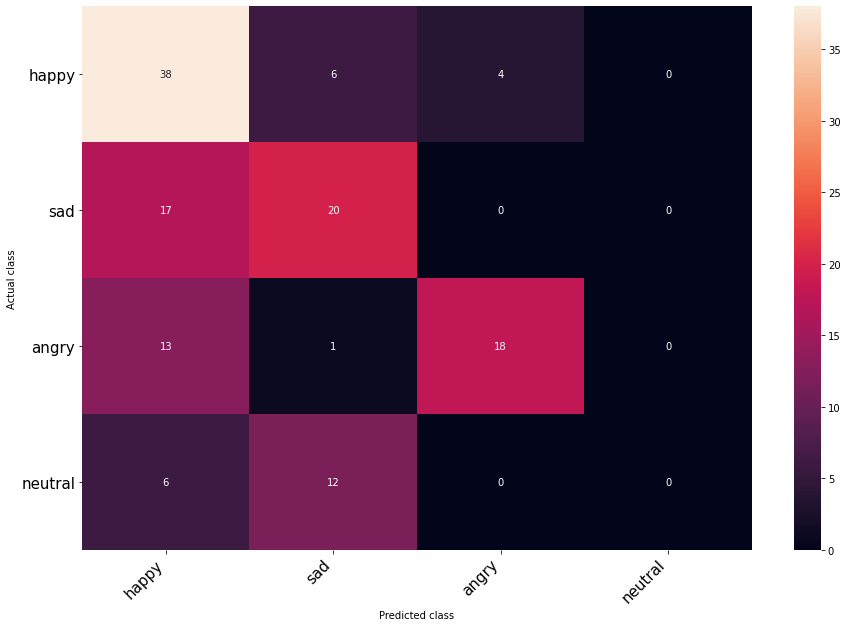

In [93]:
confusion(CNN_MFCC, mfcc_cnn_val_dl)

### Spectrogram

For our classification using Spectrograms, we will create a Convolutional Neural Network (CNN). We will then compare this to existing architecture available with Torchvision.models (2017).

#### Convolutional Neural Network (CNN)

We define our Convolution Neural Network (CNN) for Spectrograms model using PyTorch nn.Sequential.

In [94]:
CNN = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1), nn.ReLU(inplace=True),      # bs, 16, 432, 576
    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=2, padding=1), nn.ReLU(inplace=True),     # bs, 16, 432, 576
    nn.MaxPool2d(kernel_size=2, stride=2), nn.Dropout(p=0.5),                                                  # bs, 16, 216, 288
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1), nn.ReLU(inplace=True),     # bs, 32, 216, 288
    nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1), nn.ReLU(inplace=True),     # bs, 32, 216, 288
    nn.MaxPool2d(kernel_size=2, stride=2), nn.Dropout(p=0.5),                                                  # bs, 32, 108, 144
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1), nn.ReLU(inplace=True),     # bs, 64, 108, 144
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1), nn.ReLU(inplace=True),     # bs, 64, 108, 144
    nn.AdaptiveAvgPool2d((54,72)), nn.Dropout(p=0.5),                                                          # bs, 64, 54, 72
    nn.Flatten(),                                                                                              # bs, 64*54*72
    nn.Linear(in_features=(64*54*72), out_features=num_classes)                      
).to(device)

CNN

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Dropout(p=0.5, inplace=False)
  (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): Dropout(p=0.5, inplace=False)
  (12): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): AdaptiveAvgPool2d(output_size=(54, 72))
  (17): Dropout(p=0.5, inplace=False)
  (18): Flatten(start_dim=1, end_dim=-1)
  (19): Linear(in_featur

We run our model through our training/validation function.

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1	Training loss: 1.4490	Validation loss: 1.3725	Validation accuracy: 0.24


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 2	Training loss: 1.3648	Validation loss: 1.3633	Validation accuracy: 0.24


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 3	Training loss: 1.3608	Validation loss: 1.3574	Validation accuracy: 0.24


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 4	Training loss: 1.3561	Validation loss: 1.3566	Validation accuracy: 0.24


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 5	Training loss: 1.3709	Validation loss: 1.3538	Validation accuracy: 0.24
Wall time: 13.7 s


([1.4489597, 1.3647517, 1.3607571, 1.3560604, 1.3709427],
 [1.3724588, 1.3632585, 1.3573672, 1.3565519, 1.3538203])

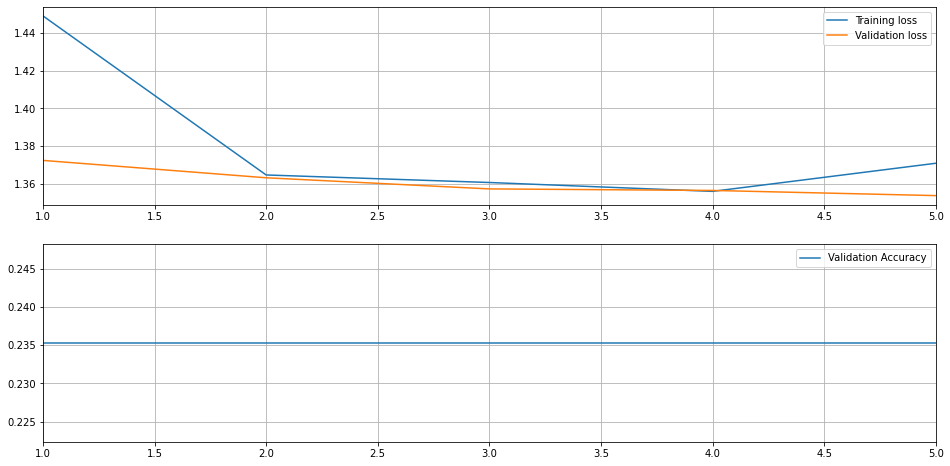

In [95]:
%%time
train_val(CNN, spec_tr_dl, spec_val_dl, epochs=5, lr=0.003)

We load the model state of our CNN with the best accuracy.

In [96]:
CNN.load_state_dict(tc.load('saved_model/CNN.pth'))
CNN.eval

<bound method Module.eval of Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Dropout(p=0.5, inplace=False)
  (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): Dropout(p=0.5, inplace=False)
  (12): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): AdaptiveAvgPool2d(output_size=(54, 72))
  (17): Dropout(p=0.5, inplace=False)
  (18): Flatten(start_dim=1, end_dim

In [97]:
%%time
print(predict(CNN, happy_im))

angry
Wall time: 11 ms


In [98]:
%%time
print(predict(CNN, angry_im))

angry
Wall time: 12 ms


In [99]:
%%time
print(predict(CNN, sad_im))

angry
Wall time: 12 ms


In [100]:
%%time
print(predict(CNN, neutral_im))

angry
Wall time: 12 ms


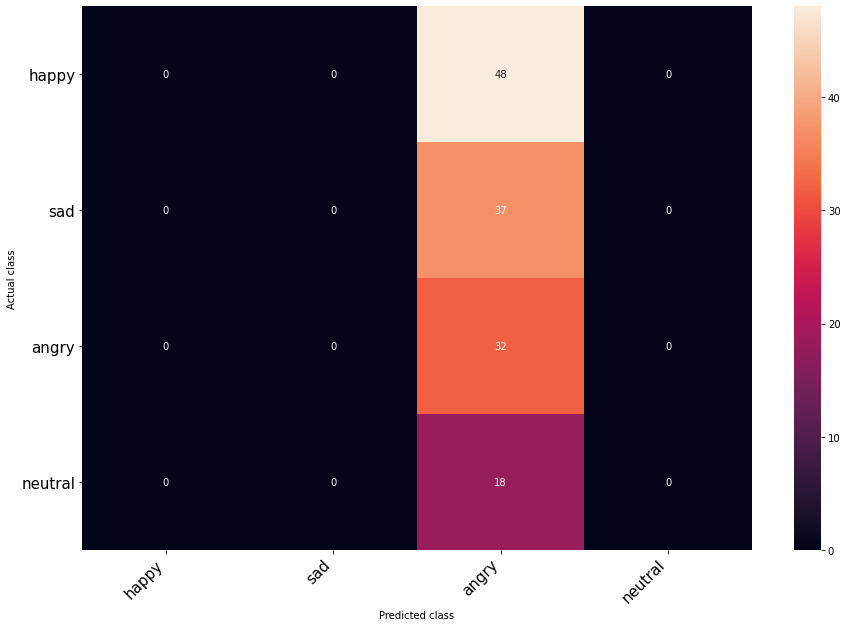

In [101]:
confusion(CNN, spec_val_dl)

#### Torchvision Models

We can now look at existing neural network achitectures available with Torchvision.models and compare how they perform with classification.

**AlexNet** is a network achitecture that was revolutionary in the advancement of CNNs in computer vision (Krizhevsky 2014).

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1	Training loss: 1.8789	Validation loss: 1.4789	Validation accuracy: 0.24


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 2	Training loss: 1.4763	Validation loss: 1.4665	Validation accuracy: 0.36


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 3	Training loss: 1.4504	Validation loss: 1.3837	Validation accuracy: 0.27


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 4	Training loss: 1.4286	Validation loss: 1.5040	Validation accuracy: 0.24


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 5	Training loss: 1.4603	Validation loss: 1.3716	Validation accuracy: 0.36
Wall time: 45.1 s


([1.8789294, 1.476287, 1.4504023, 1.428566, 1.4602869],
 [1.4788755, 1.4664918, 1.3836657, 1.5040015, 1.3715639])

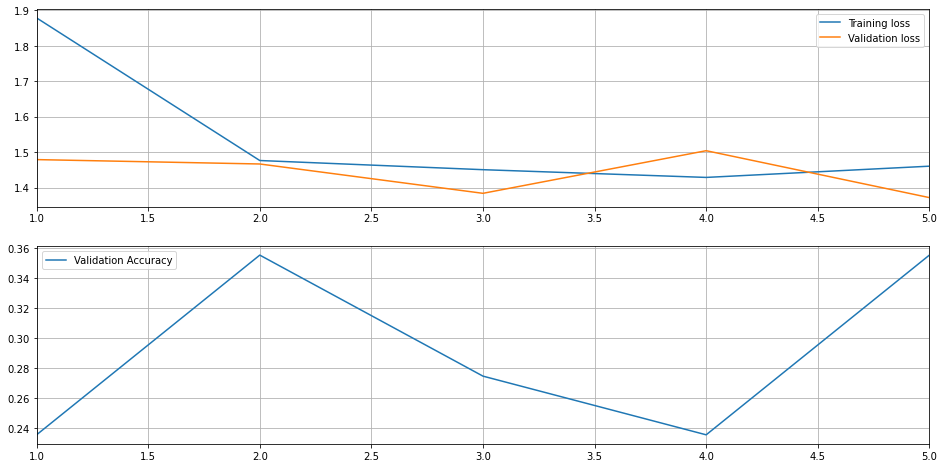

In [102]:
%%time
alexnet = models.alexnet().to(device)
train_val(alexnet, spec_tr_dl, spec_val_dl, epochs=5, lr=0.001);

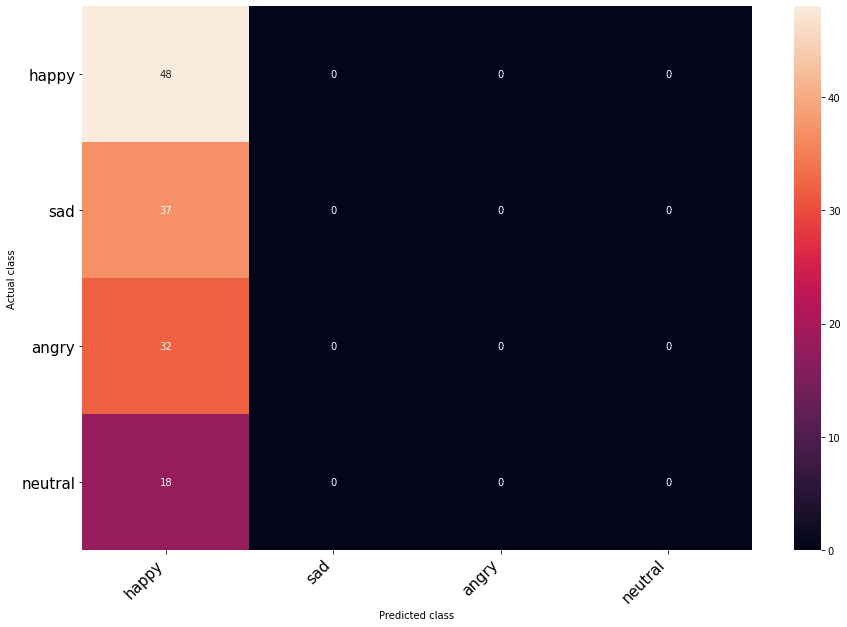

In [103]:
alexnet.load_state_dict(tc.load('saved_model/alexnet.pth'))
alexnet.eval
confusion(alexnet, spec_val_dl)

**VGG** is a network achitecture that was became very popular due to using 3x3 convolutions throughout after winning 2nd prize in the 2014 ImageNet competition (Simonyan & Zisserman 2014).

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1	Training loss: 2.3436	Validation loss: 1.6120	Validation accuracy: 0.13


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 2	Training loss: 1.4832	Validation loss: 1.3886	Validation accuracy: 0.27


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 3	Training loss: 1.4769	Validation loss: 1.3764	Validation accuracy: 0.24


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 4	Training loss: 1.5079	Validation loss: 1.3895	Validation accuracy: 0.36


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 5	Training loss: 1.4913	Validation loss: 1.3806	Validation accuracy: 0.24
Wall time: 4min 33s


([2.343601, 1.4832127, 1.4768935, 1.5078821, 1.4912536],
 [1.6120322, 1.3886331, 1.3764322, 1.3895335, 1.3805661])

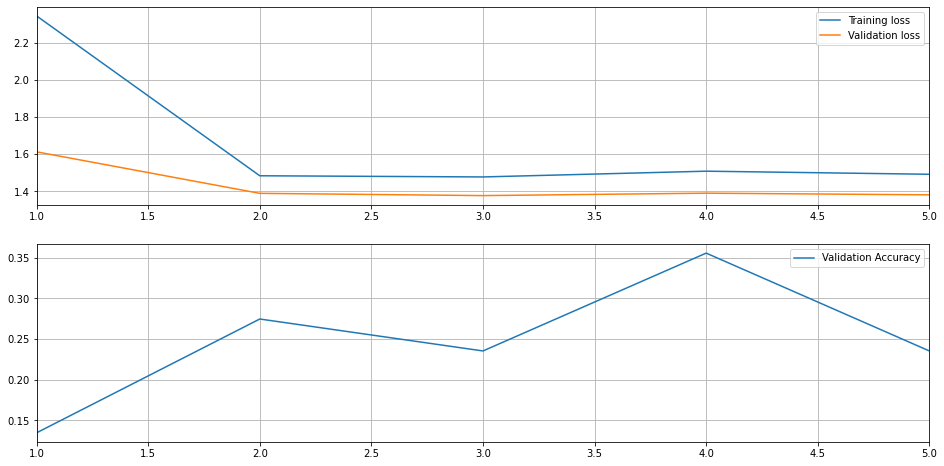

In [104]:
%%time
vgg16 = models.vgg16().to(device)
train_val(vgg16, spec_tr_dl, spec_val_dl, epochs=5, lr=0.001);

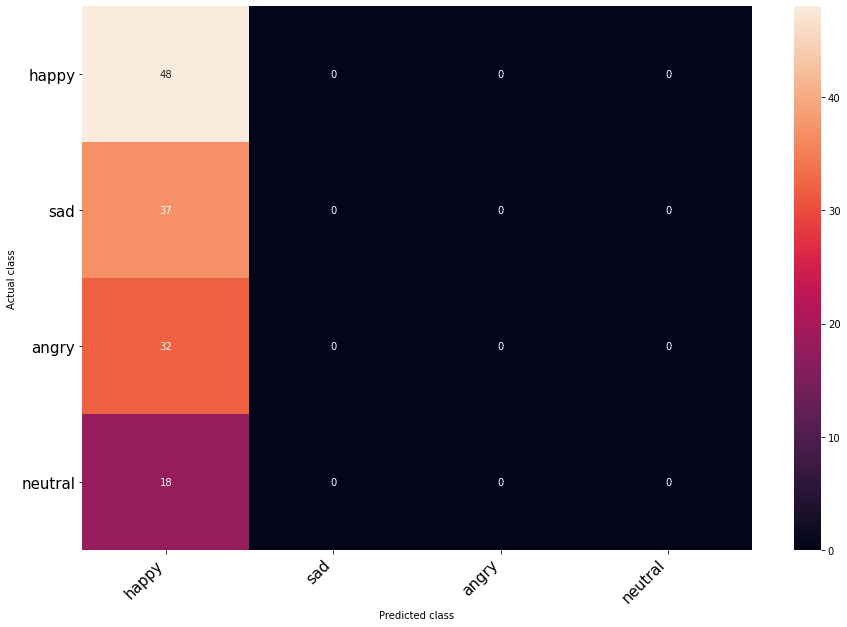

In [105]:
vgg16.load_state_dict(tc.load('saved_model/vgg16.pth'))
vgg16.eval
confusion(vgg16, spec_val_dl)

**ResNet** is a family of network architectures that make use of residual connections which are used in almost every modern computer vision architecture (He et al, 2016).

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1	Training loss: 1.6604	Validation loss: 1.9210	Validation accuracy: 0.24


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 2	Training loss: 1.3743	Validation loss: 2.1495	Validation accuracy: 0.28


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 3	Training loss: 1.3590	Validation loss: 1.6599	Validation accuracy: 0.26


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 4	Training loss: 1.3906	Validation loss: 1.9912	Validation accuracy: 0.27


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 5	Training loss: 1.3026	Validation loss: 2.3008	Validation accuracy: 0.27
Wall time: 1min 30s


([1.6604068, 1.3743261, 1.3590233, 1.3906254, 1.3025712],
 [1.9209898, 2.14953, 1.6599317, 1.9912179, 2.300806])

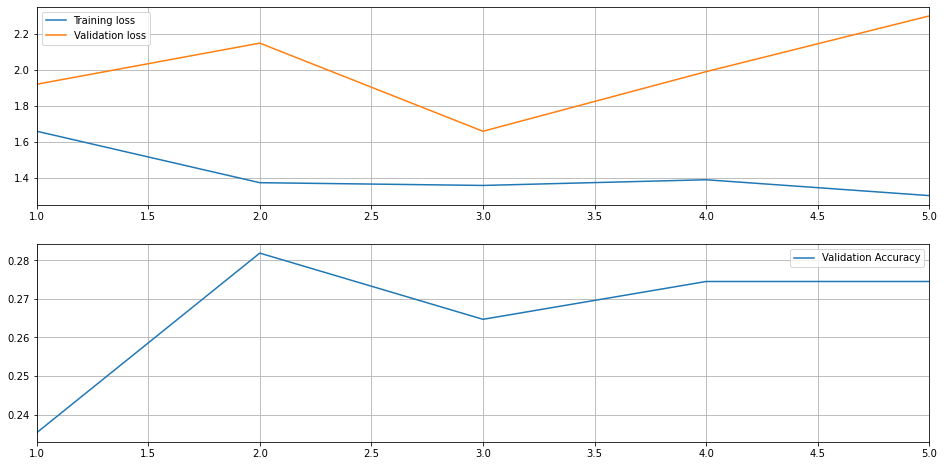

In [106]:
%%time
resnet34 = models.resnet34().to(device)
train_val(resnet34, spec_tr_dl, spec_val_dl, epochs=5, lr=0.001);

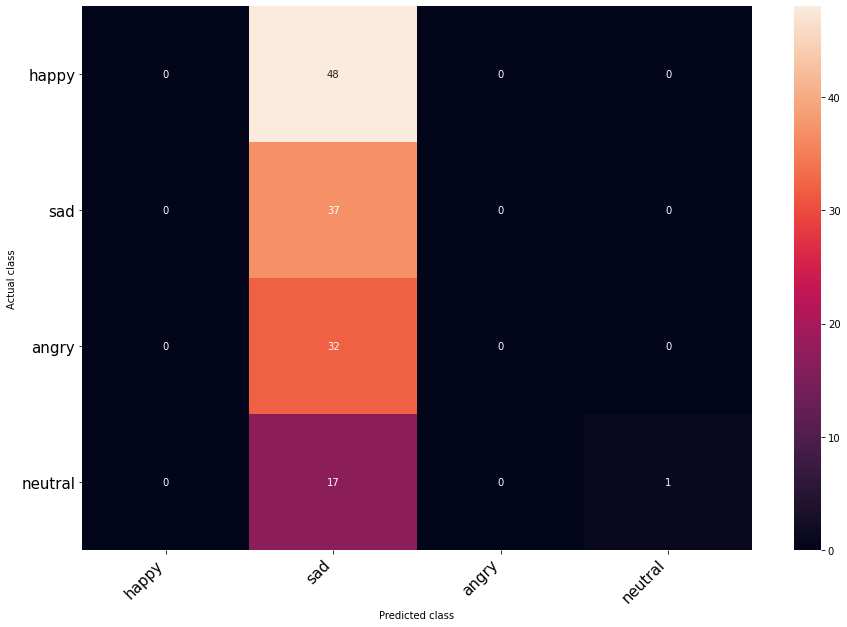

In [107]:
resnet34.load_state_dict(tc.load('saved_model/resnet34.pth'))
resnet34.eval
confusion(resnet34, spec_val_dl)

*SqueezeNet* is an architecture that focused on having high level accuracy whilst containing much less parameters than traditional achitecture, therefore being faster and using less memory (Iandola et al, 2016).

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1	Training loss: 2.5764	Validation loss: 1.6410	Validation accuracy: 0.36


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 2	Training loss: 1.5424	Validation loss: 1.4569	Validation accuracy: 0.27


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 3	Training loss: 1.4459	Validation loss: 1.4590	Validation accuracy: 0.36


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 4	Training loss: 1.4460	Validation loss: 1.5325	Validation accuracy: 0.24


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 5	Training loss: 1.4501	Validation loss: 1.5244	Validation accuracy: 0.27
Wall time: 34.1 s


([2.576422, 1.5424253, 1.4459156, 1.4460133, 1.4500504],
 [1.6409943, 1.4568863, 1.4590056, 1.5324655, 1.524427])

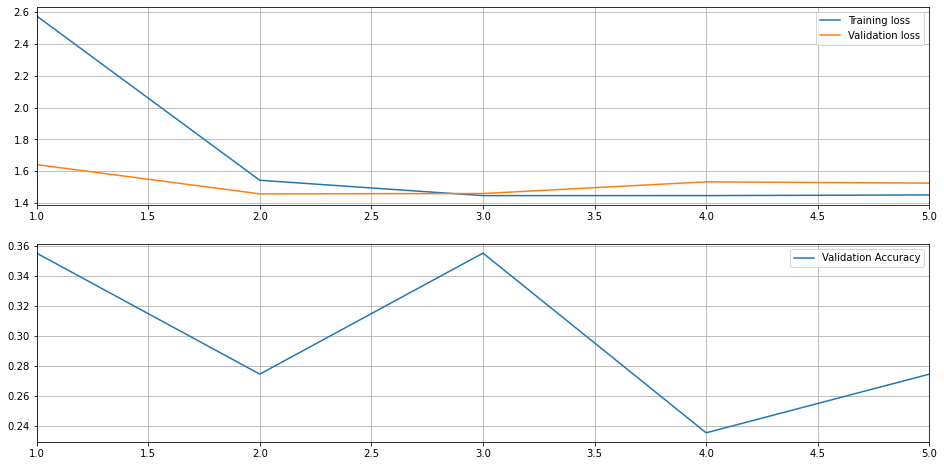

In [108]:
%%time
sqnet = models.squeezenet1_1().to(device)
train_val(sqnet, spec_tr_dl, spec_val_dl, epochs=5, lr=0.001);

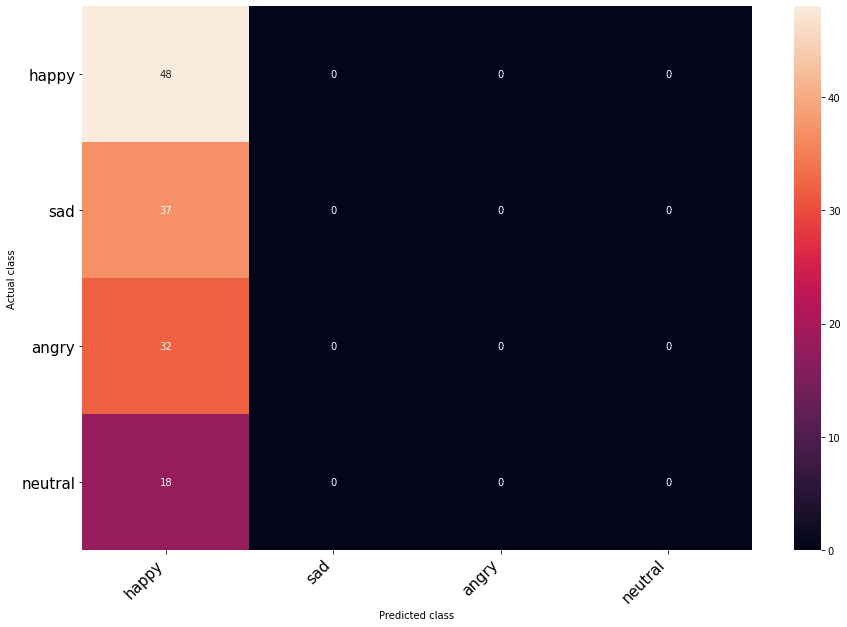

In [109]:
sqnet.load_state_dict(tc.load('saved_model/sqnet.pth'))
sqnet.eval
confusion(sqnet, spec_val_dl)

*MobileNetV2* is another lightweight architecture which aimed to provide a neural network achitecture which was lightweight enough to work on mobile devices and made use of depthwise convolutions (Sandler et al, 2018).

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1	Training loss: 1.5695	Validation loss: 1.9346	Validation accuracy: 0.24


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 2	Training loss: 1.3782	Validation loss: 1.5330	Validation accuracy: 0.22


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 3	Training loss: 1.3113	Validation loss: 1.2266	Validation accuracy: 0.42


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 4	Training loss: 1.2996	Validation loss: 1.3635	Validation accuracy: 0.47


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 5	Training loss: 1.3461	Validation loss: 2.4630	Validation accuracy: 0.27
Wall time: 1min 35s


([1.5695189, 1.3782154, 1.3112838, 1.2996492, 1.3460947],
 [1.9345714, 1.5330244, 1.2265655, 1.3634673, 2.4630325])

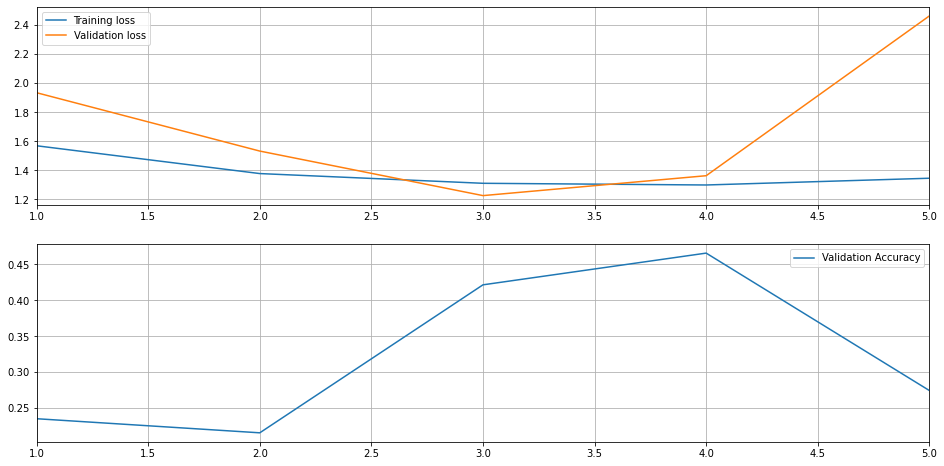

In [110]:
%%time
mbnet = models.mobilenet_v2().to(device)
train_val(mbnet, spec_tr_dl, spec_val_dl, epochs=5, lr=0.001);

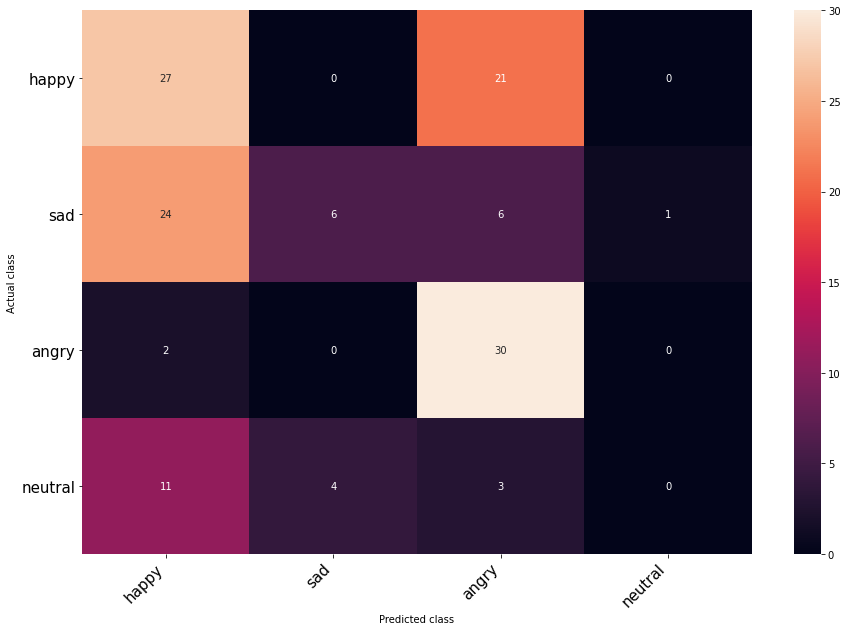

In [111]:
mbnet.load_state_dict(tc.load('saved_model/mbnet.pth'))
mbnet.eval
confusion(mbnet, spec_val_dl)

## Evaluation

### Conclusions

As can be seen in these results, classifying emotion through audio is no simple task. We achieved much better performance when classifying using MFCCs than we have using using visual spectrogram techniques, with our logistic regression classifier using MFCCs performing as our best model achieving 67% accuracy. Interestingly, MobileNetV2 was our best performing classifier using Spectrograms, achieving 47% accuracy. Looking at our confusion matrices for each classifier, we can see that the main problem for our spectrogram classification is that the differences between each spectrogram are visually so subtle that most of our classifiers recognise them all as a single class and predict every input as the same class. MobileNetV2 however doesn't seem to have this issue, which may be due the shallower network architecture using depthwise convolutions not extracting features with as much depth.

When we look at our MFCC classifiers we can see that they also struggle to get high accuracy. Looking at our confusion matrices we can see that our CNN fails to predict a single neutral class correctly, with our ANN and logistic regression classifiers also predicting the neutral class with the least accuracy. The problem here lies with the nature of neutrality itself. A "neutral" tone of speech is essentially a middle ground between every other possible tone, which causes problems when it comes to classification as these neutral instances are likely to fall slightly into the other categories. Neutral tones can also be percieved in different ways. More mild tones can be seen as slightly positive and may classify as happy and slightly negative tones may classify as sad. For both our logistic regression and ANN, the angry class is predicted correctly the most. This may be due to the angry tone being the most distinguishable and possibly the loudest of all the classes.

In conclusion, these results show that visualising audio as a mel spectrogram simply doesn't provide the learning algorithm with enough information to reliably classify emotion. The audio files in our dataset are saying the same two sentences, with only slight differences in tone which are sometimes difficult to even recognise as a human listener, especially for the neutral class, which can easily be percieved as happy or sad. If we were classifying between completely different sounds, such as between a dog barking and a car alarm, we may have had better performance using mel spectrograms, as these sounds would produce more visually distinct spectrogram images. Another way performance could be improved is if we had provided another dimension of information about the audio to the classifier alongside the spectrogram, or visualised the audio as a different kind of spectrogram which distinguishes between tonal differences better. Lastly, finding a suitable network that is pretrained on emotion recognition from speech and further training it to suit our dataset may have achieved higher accuracy.

### Future Work

In future work we would recommend testing out various other dimensions of information from the audio as input together with the mel spectrograms such as volume, energy, pitch, zero crossing rate or spectral centroid. We could also test different types of spectrograms to see if tonal differences can be visualised in a more distinguishable manner for classification. We would also recommend finding suitable pretrained algorithms and further training upon these to achieve greater accuracy with our dataset.

Further data pre-processing, such as dimensionality reduction annd feature selection could be applied to the datset to reduce the time taken to train the model without compromising the accuracy. Data augmentations like adding white noise, time shifts of the audio wave, application of time- stretching and pitch-shifting to the .wav sound file may help in better training the Neural Network.

# Music Recommendation

Our best performing model for image emotion recognition was VGG19 so we will use this algorithm in our music recommendation system using images.

Our best performing model for audio emotion recognition was logistic regression so we will use this algorithm in our music recommendation system using audio.

In [87]:
def music(input_type, filename):
    
    if input_type == 'image':
        prediction = emotion_img(filename)
    
    if input_type == 'audio':
        prediction = predict(LogReg, filename)
    
    if prediction == 'happy':
        return ipd.IFrame(src="https://www.youtube.com/embed/ZbZSe6N_BXs", width=560, height=315)
    elif prediction == 'sad':
        return ipd.IFrame(src="https://www.youtube.com/embed/8AHCfZTRGiI", width=560, height=315)
    elif prediction == 'angry':
        return ipd.IFrame(src="https://www.youtube.com/embed/bWXazVhlyxQ", width=560, height=315)
    elif prediction == 'neutral':
        return ipd.IFrame(src="https://www.youtube.com/embed/yWeuUwpEQfs", width=560, height=315)


In [90]:
%%time
music(input_type='image', filename=happy_salah)

Wall time: 81.8 ms


As we can see our music recommendation system using image emotion recognition correctly identifies the image as happy and recommends happy music.

In [55]:
%%time
music(input_type='audio', filename=happy)

Wall time: 21 ms


In [56]:
%%time
music(input_type='audio', filename=angry)

Wall time: 20 ms


In [57]:
%%time
music(input_type='audio', filename=sad)

Wall time: 21 ms


In [58]:
%%time
music(input_type='audio', filename=neutral)

Wall time: 20 ms


As can be seen, our music recommendation system achieved 3 out of 4 of the emotions correct with audio emotion recognition using our logistic regression algorithm.

# References

He, K., Zhang, X., Ren, S. and Sun, J., 2016. Deep residual learning for image recognition. *In Proceedings of the IEEE conference on computer vision and pattern recognition* [online], (2016), 770-778.

Iandola, F.N., Han, S., Moskewicz, M.W., Ashraf, K., Dally, W.J. and Keutzer, K., 2016. SqueezeNet: AlexNet-level accuracy with 50x fewer parameters and< 0.5 MB model size. *arXiv preprint* [online], (2016), arXiv:1602.07360.

Krizhevsky, A., 2014. One weird trick for parallelizing convolutional neural networks. *arXiv preprint* [online], (2014), arXiv:1404.5997.

Livingstone, S. R. & Russo, F. A., 2018. *The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)* [online].  Geneva: Zenodo. http://doi.org/10.5281/zenodo.1188976.

Medium, 2021. *Understanding the Mel Spectrogram* [online]. San Francisco: Medium. Available from: https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53 [Accessed 12 May 2021].

O‘Shaughnessy, D., 1997. Human and machine. *Speech Communication* [online], 2, 41-127.

PyTorch, 2017. *TORCHVISION.MODELS* [online]. PyTorch. Available from: https://pytorch.org/vision/stable/models.html [Accessed 11 May 2021].

Sandler, M., Howard, A., Zhu, M., Zhmoginov, A. and Chen, L.C., 2018. Mobilenetv2: Inverted residuals and linear bottlenecks. *In Proceedings of the IEEE conference on computer vision and pattern recognition* [online], (2018), 4510-4520).

Sahidullah, M. and Saha, G., 2012. Design, analysis and experimental evaluation of block based transformation in MFCC computation for speaker recognition. *Speech Communication* [online], 54 (4), 543-565.

Simonyan, K. and Zisserman, A., 2014. Very deep convolutional networks for large-scale image recognition. *arXiv preprint* [online], (2014), arXiv:1409.1556.